# Autoencoder Learning Experiment
In this version, we try not to generate data based on real formants, but instead a toy data that roughly reflects the distribution but somewhat seems like the normalized version without being really normalized. This is mainly to tackle the problem of different ranges of variances for different formants, which should be tied to their specific means (larger value range, larger variance values)

In version 3, we additionally compare the model with very little cross-phonemic contrast

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import calendar;
import time; # Importing necessary libraries
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader

from src.linear_ae_net.dynamics import *

## Generate Dataset and define model

In [2]:
def generate_gmm_data(d, n_components=4, random_state=42, num_data=1000, 
                            means=None, vars=None, sizes=None, tags=None):
    """
    Generate a GMM dataset with exact cluster sizes and custom string labels.

    - sizes: list of exact number of samples for each component; sum(sizes) == num_data
    - tags: list of string labels for each component

    Returns:
    - X: (num_data, d)
    - labels: (num_data,) array of strings (from tags)
    """
    rng = np.random.default_rng(random_state)

    if sizes is None:
        sizes = [num_data // n_components] * n_components
        sizes[-1] += num_data - sum(sizes)
    else:
        sizes = list(sizes)
        assert len(sizes) == n_components, "Sizes must match the number of components"
        num_data = sum(sizes)   # adjust num_data to match sizes

    if tags is None:
        tags = [str(i) for i in range(n_components)]
    else:
        assert len(tags) == n_components

    if means is None:
        means = rng.uniform(-20, 20, size=(n_components, d))
    else:
        means = np.array(means, dtype=float)
        assert means.shape == (n_components, d)

    if vars is None:
        covariances = [np.diag(rng.uniform(0.1, 0.2, size=d)) for _ in range(n_components)]
    else:
        covariances = [np.diag([var]*d) for var in vars]

    X = []
    labels = []
    for k in range(n_components):
        Xk = rng.multivariate_normal(means[k], covariances[k], size=sizes[k])
        X.append(Xk)
        labels.extend([tags[k]] * sizes[k])
    X = np.vstack(X)
    labels = np.array(labels)
    perm = rng.permutation(num_data)
    return X[perm], labels[perm]

def zscore_normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)

In [3]:
def plot_2d_projection_with_principal_axes(X, labels, dim_x=0, dim_y=1, label_names=None):
    """
    X: (N, d) array (d >= 2)
    labels: length-N int or string labels
    dim_x, dim_y: which dimensions to plot (0-based)
    label_names: list of label strings, or None to skip legend
    """
    # Map string labels to numeric for color
    label_names_unique, labels_numeric = np.unique(labels, return_inverse=True)
    
    # Compute mean and covariance in full space
    mu = X.mean(axis=0)
    C = np.cov(X, rowvar=False)
    U, S, Vt = np.linalg.svd(C)

    # 2D mean for plot
    mu2 = mu[[dim_x, dim_y]]

    plt.figure(figsize=(7, 7))
    # Scatterplot of projection
    plt.scatter(X[:, dim_x], X[:, dim_y], c=labels_numeric, alpha=0.6, cmap='tab10', label='')

    # Draw and label first two principal axes, projected
    for i in range(4):
        vec = U[:, i] * np.sqrt(S[i])
        vec2 = vec[[dim_x, dim_y]]
        plt.arrow(mu2[0], mu2[1], vec2[0], vec2[1], width=0.05, length_includes_head=True, label=f'σ{i+1}')
        plt.arrow(mu2[0], mu2[1], -vec2[0], -vec2[1], width=0.05, length_includes_head=True)
        plt.text(mu2[0] + vec2[0]*1.1, mu2[1] + vec2[1]*1.1, f'({i}){S[i]:.2f}', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.xlabel(f"Dimension {dim_x+1}")
    plt.ylabel(f"Dimension {dim_y+1}")
    plt.title("GMM Samples: Principal Axes & Singular Values (Projected)")
    plt.grid(True)

    # Legend with class names, if available
    if label_names is not None:
        for i, name in enumerate(label_names_unique):
            plt.scatter([], [], c=[plt.cm.tab10(i)], label=name)
        plt.legend(title="Class")

    plt.show()

    # 1) Covariance matrix heatmap
    C = np.cov(X, rowvar=False)
    plt.figure()
    plt.imshow(C, aspect='equal')
    plt.colorbar()
    plt.title("Covariance Matrix")
    plt.xlabel("Dimension")
    plt.ylabel("Dimension")
    plt.show()

    # 2) Singular values
    U, S, Vt = np.linalg.svd(C)
    plt.figure()
    plt.bar(np.arange(1, len(S)+1), S)
    plt.xlabel("Component")
    plt.ylabel("Singular Value")
    plt.title("Singular Values of Covariance Matrix")
    plt.show()


def plot_2d_projection_with_principal_axes_2(X, labels, dim_x=0, dim_y=1, label_names=None):
    """
    X: (N, d) array (d >= 2)
    labels: length-N int or string labels
    dim_x, dim_y: which dimensions to plot (0-based)
    label_names: list of label strings, or None to skip legend
    """
    # Map string labels to numeric for color
    label_names_unique, labels_numeric = np.unique(labels, return_inverse=True)
    
    # Compute mean and covariance in full space
    mu = X.mean(axis=0)
    # C = np.cov(X, rowvar=False)
    C = compute_correlation_matrix(X, X)
    U, S, Vt = np.linalg.svd(C)

    # 2D mean for plot
    mu2 = mu[[dim_x, dim_y]]

    plt.figure(figsize=(7, 7))
    # Scatterplot of projection
    plt.scatter(X[:, dim_x], X[:, dim_y], c=labels_numeric, alpha=0.6, cmap='tab10', label='')

    # Draw and label first two principal axes, projected
    for i in range(4):
        vec = U[:, i] * np.sqrt(S[i])
        vec2 = vec[[dim_x, dim_y]]
        plt.arrow(mu2[0], mu2[1], vec2[0], vec2[1], width=0.05, length_includes_head=True, label=f'σ{i+1}')
        plt.arrow(mu2[0], mu2[1], -vec2[0], -vec2[1], width=0.05, length_includes_head=True)
        plt.text(mu2[0] + vec2[0]*1.1, mu2[1] + vec2[1]*1.1, f'{S[i]:.2f}', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.xlabel(f"Dimension {dim_x+1}")
    plt.ylabel(f"Dimension {dim_y+1}")
    plt.title("GMM Samples: Principal Axes & Singular Values (Projected)")
    plt.grid(True)

    # Legend with class names, if available
    if label_names is not None:
        for i, name in enumerate(label_names_unique):
            plt.scatter([], [], c=[plt.cm.tab10(i)], label=name)
        plt.legend(title="Class")

    plt.show()

    # 1) Covariance matrix heatmap
    # C = np.cov(X, rowvar=False)
    C = compute_correlation_matrix(X, X)
    plt.figure()
    plt.imshow(C, aspect='equal')
    plt.colorbar()
    plt.title("Covariance Matrix")
    plt.xlabel("Dimension")
    plt.ylabel("Dimension")
    plt.show()

    # 2) Singular values
    U, S, Vt = np.linalg.svd(C)
    plt.figure()
    plt.bar(np.arange(1, len(S)+1), S)
    plt.xlabel("Component")
    plt.ylabel("Singular Value")
    plt.title("Singular Values of Covariance Matrix")
    plt.show()

In [4]:
class LinearAutoEncoder():
    '''Neural network class'''
    def __init__(self):
        self.history = {'loss': [], 'val_loss': [], 'weights': {'W1':[], 'W2':[]}, 'activations': [], 'testing_activations': [], 'z_testing_activations': []}
    
    def train(self, X, X_val=None, input_dim=5, n_epoch=100, hidden_dim=100, learning_rate=0.1, reg_param=0.0001, 
              noise='gaussian', noise_scale=1, verbose=False, Y=None, Y_val=None, Z=None, Z_val=None):
        """
        Y: testing data
        """
        self.y_val = Y_val
        dtype = torch.cuda.FloatTensor
        X_in = X.clone().type(dtype)
        X = X.type(dtype)
        N = X.shape[0]
        D = X.shape[1]
        
        self.strenghts = torch.zeros((1, D)).type(dtype)
        self.W1 = 0.0001*torch.randn(X.shape[1], hidden_dim).type(dtype)
        self.W2 = 0.0001*torch.randn(hidden_dim, input_dim).type(dtype)

        W = self.W1.mm(self.W2)
        s_int = np.linalg.svd(W.cpu().numpy(), compute_uv=0)
        self.init = np.sum(s_int[:100])/len(s_int)

        corr_mat = compute_correlation_matrix(X.cpu().numpy(), X.cpu().numpy())
        self.U, self.S, self.Vt = np.linalg.svd(corr_mat)

        UZ = torch.from_numpy((Z.cpu().numpy() @ self.U.T)) if Z is not None else None
        
        for t in range(n_epoch):
            
            W1 = self.W1
            W2 = self.W2
            
            # compute scores
            h1 = X_in.mm(W1)
            scores = h1.mm(W2)

            # compute loss
            data_loss = 0.5*((scores - X).pow(2).sum())/N
            noise_loss = 0.5*noise_scale*torch.trace(W2.t().mm(W1.t()).mm(W1).mm(W2))
            reg_loss = 0.5*reg_param*torch.sum(W1*W1) + 0.5*reg_param*torch.sum(W2*W2)
            loss = data_loss + noise_loss + reg_loss
                    
            # store loss
            self.history['loss'].append(loss)
        
            # compute the gradient using backpropagation
            dscores = (scores - X)/N
            dW2 = h1.t().mm(dscores)
            dhidden = dscores.mm(W2.t())
            dW1 = X_in.t().mm(dhidden)
            
            # add regularisation gradients
            dW2 += reg_param*W2
            dW1 += reg_param*W1
            
            # add noise gradients
            dW1 += noise_scale*W1.mm(W2).mm(W2.t())
            dW2 += noise_scale*W1.t().mm(W1).mm(W2)

            # perform parameter updates
            self.W1 += -learning_rate*dW1
            self.W2 += -learning_rate*dW2
            
            # compute validation loss
            if X_val is not None:
                val_pred = self.predict(X_val)
                val_loss = 0.5*(X_val - val_pred).pow(2).sum()/N
                self.history['val_loss'].append(val_loss)
                if verbose:
                    if t % 100 == 0:
                        print('iteration: ', t, 'training loss: ', loss, ' validation loss: ', val_loss)
            else:
                if verbose:
                    if t % 100 == 0:
                        print('iteration: ', t, 'training loss: ', loss)
            
            # compute eigenvalues
            if t % 10 == 0:
                W = self.W1.mm(self.W2)
                # W = self.W1
                s = np.linalg.svd(W.cpu().numpy(), compute_uv=0)
                s = torch.unsqueeze(torch.from_numpy(s).type(dtype), 1).t()
                self.strenghts = torch.cat((self.strenghts, s), dim=0)

                testing_activations = self.encode(Y.type(dtype))
                z_testing_activations = self.encode(UZ.type(dtype)) if Z is not None else 0.0
                
                self.history['weights']['W1'].append(W1.cpu().numpy().copy())
                self.history['weights']['W2'].append(W2.cpu().numpy().copy())
                self.history['activations'].append(h1.cpu().numpy().copy())
                self.history['testing_activations'].append(testing_activations.cpu().numpy().copy())
                self.history['z_testing_activations'].append(z_testing_activations.cpu().numpy().copy())
        
    def predict(self, X):
        W1 = self.W1
        W2 = self.W2
        h1 = X.type(torch.cuda.FloatTensor).mm(W1)
        scores = h1.mm(W2)
        return scores
    
    def encode(self, X):
        W1 = self.W1
        W2 = self.W2
        h1 = X.type(torch.cuda.FloatTensor).mm(W1)
        # scores = h1.mm(W2)
        return h1

In [5]:
def average_inner_product(X1, X2):
    # X1, X2: arrays of shape (N1, D), (N2, D)
    # Compute inner products for all pairs, return the mean
    ip = np.dot(X1, X2.T)  # shape (N1, N2)
    return ip.mean()

def average_cosine_similarity(A, B):
    """
    Computes cosine similarity between all pairs of rows in A (N1, D) and B (N2, D)
    Returns an (N1, N2) matrix of similarities.
    """
    # Normalize each row to unit length
    A_norm = A / np.linalg.norm(A, axis=1, keepdims=True)
    B_norm = B / np.linalg.norm(B, axis=1, keepdims=True)
    # Compute cosine similarity as dot product
    sim_matrix = np.dot(A_norm, B_norm.T)
    return sim_matrix.mean()  # shape (N1, N2)

def average_euclidean_distance(A, B):
    """
    Returns the matrix of Euclidean distances between all pairs in A (N1, D) and B (N2, D)
    Output: (N1, N2)
    """
    # Efficient computation: (a - b)^2 = a^2 + b^2 - 2ab
    A_sq = np.sum(A**2, axis=1, keepdims=True)  # (N1, 1)
    B_sq = np.sum(B**2, axis=1, keepdims=True).T  # (1, N2)
    cross = np.dot(A, B.T)  # (N1, N2)
    dist_sq = A_sq + B_sq - 2 * cross
    dist_sq = np.maximum(dist_sq, 0.0)  # for numerical safety
    distances = np.sqrt(dist_sq)
    return distances.mean()  # shape (N1, N2)

def similarity_trajectory(recon_test, labels_test, label_a, label_b, calculator=average_inner_product):
    sims = []
    for epoch_data in recon_test:  # each is (N_test, D)
        idx_a = np.where(labels_test == label_a)[0]
        idx_b = np.where(labels_test == label_b)[0]
        X_a = epoch_data[idx_a]
        X_b = epoch_data[idx_b]
        sim = calculator(X_a, X_b)
        sims.append(sim)
    return sims

def similarity_trajectory_normalized(recon_test, ori_test, labels_test, label_a, label_b, calculator=average_inner_product):
    sims = []
    for epoch_data in recon_test:  # each is (N_test, D)
        idx_a = np.where(labels_test == label_a)[0]
        idx_b = np.where(labels_test == label_b)[0]
        X_a = epoch_data[idx_a]
        X_b = epoch_data[idx_b]
        sim = calculator(X_a, X_b)

        ori_sim = calculator(ori_test[idx_a], ori_test[idx_b])
        norm_sim = sim / ori_sim if ori_sim != 0 else 0
        sims.append(norm_sim)
    return sims

In [20]:
import numpy as np
import pandas as pd

def angles_feature_axes_vs_pcs(
    X,
    n_components=None,
    standardize=True,
    feature_names=None,
    topk_for_subspace=None,
    eps=1e-12,
):
    """
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix.
    n_components : int or None
        Number of principal components to keep (default: all).
    standardize : bool
        If True, z-score features before PCA (recommended when scales differ).
    feature_names : list[str] or None
        Optional names for features; defaults to 0..D-1.
    topk_for_subspace : int or None
        If provided, also compute angle between each feature axis and the
        subspace spanned by the first 'topk_for_subspace' PCs.
    eps : float
        Numerical stability.
    
    Returns
    -------
    angles_df : pd.DataFrame
        Angles (degrees, 0..90) between each feature axis and each PC.
        Index = feature, columns = PC1..PCk.
    subspace_angles : pd.Series or None
        Angles (degrees, 0..90) between each feature axis and the top-k PC subspace,
        or None if 'topk_for_subspace' is None.
    pcs : np.ndarray, shape (k, D)
        Row-wise PC directions in feature space (unit vectors).
    explained_var_ratio : np.ndarray, shape (k,)
        Explained variance ratio per PC.
    """
    X = np.asarray(X, dtype=float)
    n, D = X.shape
    if n_components is None:
        n_components = D
    n_components = min(n_components, D)

    # Center
    Xc = X - X.mean(axis=0, keepdims=True)

    # Optional standardization (z-score)
    if standardize:
        std = Xc.std(axis=0, ddof=1)
        std[std < eps] = 1.0  # avoid div-by-zero
        Xc = Xc / std

    corr_mat = compute_correlation_matrix(X, X)
    # SVD-based PCA: Xc = U S V^T; rows of V^T are PCs in feature space
    U, S, Vt = np.linalg.svd(corr_mat, full_matrices=False)
    Vt = Vt[:n_components, :]  # shape (k, D)
    S = S[:n_components]
    # Explained variance ratio
    var = (S**2) / (n - 1)
    total_var = (Xc**2).sum() / (n - 1)
    explained_var_ratio = var / (total_var + eps)

    # Prepare feature names
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(D)]
    assert len(feature_names) == D, "feature_names must match number of columns"

    # Angles between basis e_i and PC_j:
    # angle = arccos(|dot(e_i, pc_j)|) = arccos(|pc_j[i]|), since ||e_i||=1 and pc_j unit
    pcs = Vt  # rows: PC_j in feature coords (unit)
    cosines = np.abs(pcs)  # |pc_j[i]|
    cosines = np.clip(cosines, 0.0, 1.0)
    angles_rad = np.arccos(cosines)  # in radians
    angles_deg = np.degrees(angles_rad)  # 0..90

    angles_df = pd.DataFrame(
        angles_deg.T,  # rows = features
        index=feature_names,
        columns=[f"PC{j+1}" for j in range(n_components)],
    )

    # Optional: principal angle between e_i and span(PC_1..PC_k)
    subspace_angles = None
    if topk_for_subspace is not None and topk_for_subspace > 0:
        k = min(topk_for_subspace, n_components)
        # Orthonormal basis for subspace: rows pcs[:k] are orthonormal
        Q = pcs[:k, :]  # (k, D)
        # For each e_i, projection norm = ||Q @ e_i|| = sqrt(sum_j Q[j, i]^2)
        proj_norms = np.sqrt((Q[:, :]**2).sum(axis=0))  # length D
        proj_norms = np.clip(proj_norms, 0.0, 1.0)
        # angle = arccos(||projection||), since ||e_i||=1
        sub_angles = np.degrees(np.arccos(proj_norms))
        subspace_angles = pd.Series(sub_angles, index=feature_names, name=f"angle_to_span(PC1..PC{k})")

    return angles_df, subspace_angles, pcs, explained_var_ratio

In [18]:
data_train

array([[-0.63569788,  1.02573786,  0.06416778, -0.05536841],
       [ 1.32963571,  1.03519241,  0.31492722, -0.14750009],
       [-0.98291666,  1.12041252,  0.44752307,  0.12573994],
       ...,
       [-1.23456798,  1.07113607, -0.31877949, -0.20707433],
       [ 0.9052622 , -0.73652865,  0.16733167,  0.13438431],
       [-1.33598544, -0.99207416,  0.05924526,  0.04001771]],
      shape=(1000, 4))

In [21]:
angles_df, subspace_angles, pcs, evr = angles_feature_axes_vs_pcs(
    data_train,
    n_components=None,
    standardize=True,
    feature_names=["H", "B", "R", "L"],
    topk_for_subspace=2,
)

print("Angles (deg) between feature axes and PCs:\n", angles_df.round(2))
if subspace_angles is not None:
    print("\nAngle to span(PC1..PC2):\n", subspace_angles.round(2))
print("\nExplained variance ratio:", np.round(evr, 4))

Angles (deg) between feature axes and PCs:
      PC1    PC2    PC3    PC4
H   0.27  89.87  89.78  89.92
B  89.87   0.85  89.29  89.56
R  89.78  89.28   0.83  89.65
L  89.92  89.56  89.64   0.57

Angle to span(PC1..PC2):
 H     0.24
B     0.84
R    89.25
L    89.56
Name: angle_to_span(PC1..PC2), dtype: float64

Explained variance ratio: [269.2957 111.035    1.8103   0.5885]


In [26]:
import numpy as np
import pandas as pd

def feature_as_linear_combo_of_pcs(
    X,
    n_components=None,
    standardize=True,
    feature_names=None,
    topk=None,
    eps=1e-12,
):
    """
    Express each feature axis e_i as a linear combination of PCs:
        e_i = sum_j coeffs[j,i] * PC_j
    where coeffs is the PC matrix V (rows = PCs, columns = features).

    Returns
    -------
    coeffs_df : DataFrame (features x PCs)
        Coefficients to write each feature axis in the PC basis.
    residual_norm : Series (features,)
        If 'topk' is set, residual norm ||e_i - P_k e_i||; else None.
    pcs : ndarray (k, D)
        PC directions (unit), rows = PC_j in feature space.
    evr : ndarray (k,)
        Explained variance ratio.
    """
    X = np.asarray(X, dtype=float)
    n, D = X.shape
    if n_components is None:
        n_components = D
    n_components = min(n_components, D)

    corr_mat = compute_correlation_matrix(X, X)
    # PCA via SVD: Xc = U S V^T, rows of V^T are PCs
    U, S, Vt = np.linalg.svd(corr_mat, full_matrices=False)
    pcs = Vt[:n_components, :]  # shape (k, D), each row unit-length
    var = (S[:n_components]**2) / (n - 1)
    total_var = (corr_mat**2).sum() / (n - 1)
    evr = var / (total_var + eps)

    # Coeffs to express e_i in PC basis: column i of V (i.e., pcs[:, i])
    # Build a tidy DataFrame: rows=features, cols=PC1..PCk
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(D)]
    assert len(feature_names) == D

    coeffs = pcs  # (k, D)
    coeffs_df = pd.DataFrame(
        coeffs.T,  # (D, k)
        index=feature_names,
        columns=[f"PC{j+1}" for j in range(coeffs.shape[0])],
    )

    # Optional: restrict to top-k PCs and report residual
    residual_norm = None
    if topk is not None:
        k = min(topk, coeffs.shape[0])
        proj_norm = np.sqrt((coeffs[:k, :]**2).sum(axis=0))  # length-D
        residual = np.sqrt(np.maximum(0.0, 1.0 - proj_norm**2))
        residual_norm = pd.Series(residual, index=feature_names, name=f"||residual|| (top-{k})")

        # Also trim the displayed coefficients to top-k if you prefer:
        coeffs_df = coeffs_df.iloc[:, :k]

    return coeffs_df, residual_norm, pcs, evr

# ---- Example ----
if __name__ == "__main__":
    coeffs_df, resid, pcs, evr = feature_as_linear_combo_of_pcs(
        data_train, n_components=None, standardize=True,
        feature_names=["H", "B", "R", "L"],
        
    )

    print("Linear expression coefficients (each row e_i in PC basis):")
    print(coeffs_df.round(4))
    if resid is not None:
        print("\nResidual norms using only top-2 PCs:")
        print(resid.round(4))


Linear expression coefficients (each row e_i in PC basis):
      PC1     PC2     PC3     PC4
H -1.0000 -0.0022  0.0039  0.0014
B  0.0022 -0.9999 -0.0124 -0.0077
R -0.0039  0.0125 -0.9999 -0.0062
L  0.0014 -0.0076 -0.0063  1.0000


## Training

### Case 1: Two Large Contrast

#### Data Generation and Visualization

In [46]:
# training means and shared std
# height, backness, rounding, length (any unrelated feature)
means_train = [
    np.array([1.0, 0.8, 0.2, 0.0]),  # /i/
    np.array([1.0, -0.8, 0.2, 0.0]),  # /ɯ/
    np.array([-1.0, 0.8, 0.2, 0.0]),  # /ɛ/
    np.array([-1.0, -0.8, 0.2, 0.0]),  # /ʌ/
]
var_strength = 0.001  # same in all dimensions
vars_train = [var_strength] * len(means_train)
sizes_train = [1000 // len(means_train)] * len(means_train)  # for example
tags_train = ["i", "ɯ", "ɛ", "ʌ"] 

means_test = [
    np.array([1.0, 0.8, 0.2, 0.0]),  # /i/
    np.array([1.0, -0.8, 0.2, 0.0]),  # /ɯ/
    np.array([-1.0, 0.8, 0.2, 0.0]),  # /ɛ/
    np.array([-1.0, -0.8, 0.2, 0.0]),  # /ʌ/
    np.array([1.0, 0.8, -0.2, 0.0]),  # /y/
    np.array([1.0, -0.8, -0.2, 0.0]),  # /u/
    np.array([-1.0, 0.8, -0.2, 0.0]),  # /œ/
    np.array([-1.0, -0.8, -0.2, 0.0]),  # /ɔ/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [500] * len(means_test)  # for example
tags_test = ["i", "ɯ", "ɛ", "ʌ", "y", "u", "œ", "ɔ"]

data_train, labels_train = generate_gmm_data(d=4, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=4, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

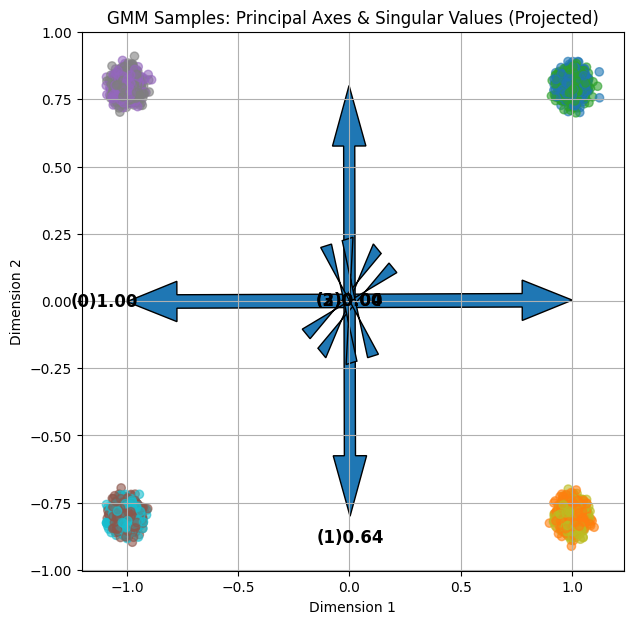

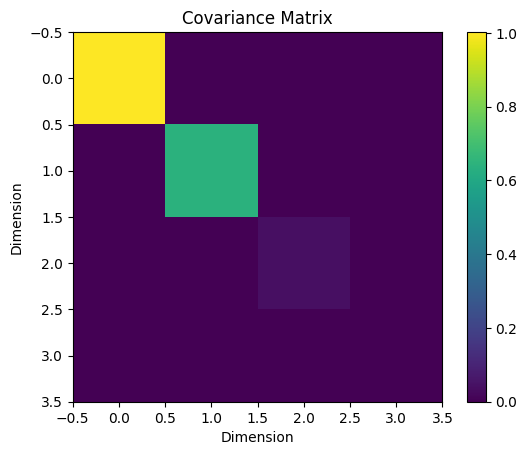

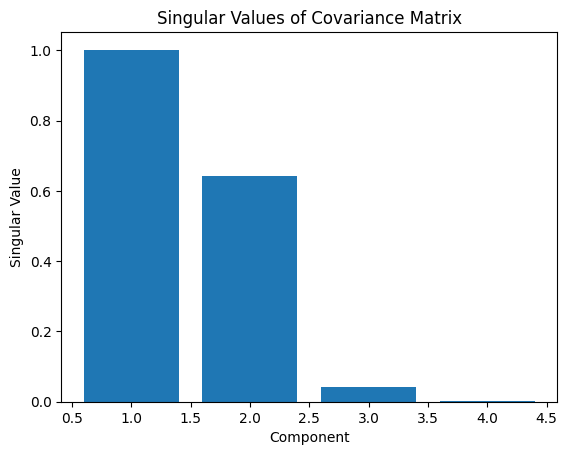

In [47]:
plot_2d_projection_with_principal_axes(data_test, labels_test, dim_x=0, dim_y=1)

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tokens_2d(data_test, label_test, dim_x=0, dim_y=1, figsize=(6,6), alpha=0.7, selected_labels=None):
    """
    2-D scatter plot of selected dimensions of data_test, colored by label_test.

    Parameters
    ----------
    data_test : array-like, shape (N, D)
        Test data matrix.
    label_test : array-like, shape (N,)
        Labels or token types corresponding to each data point.
    dim_x : int
        Index of the feature to use for the x-axis.
    dim_y : int
        Index of the feature to use for the y-axis.
    figsize : tuple
        Figure size.
    alpha : float
        Point transparency.
    """
    data_test = np.asarray(data_test)
    label_test = np.asarray(label_test)

    # Unique labels
    labels = np.unique(label_test)
    plt.figure(figsize=figsize)

    for lab in labels:
        mask = label_test == lab
        plt.scatter(
            data_test[mask, dim_x],
            data_test[mask, dim_y],
            label=str(lab),
            alpha=alpha
        )

    plt.xlabel(f"Dimension {dim_x}")
    plt.ylabel(f"Dimension {dim_y}")
    plt.title(f"2D plot: dim {dim_x} vs dim {dim_y}")
    plt.legend(title="Tokens", loc="best", fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def select_tokens(data, labels, target_tokens):
    data = np.asarray(data)
    labels = np.asarray(labels)

    mask = np.isin(labels, target_tokens)
    data_selected = data[mask]
    labels_selected = labels[mask]

    return data_selected, labels_selected, mask

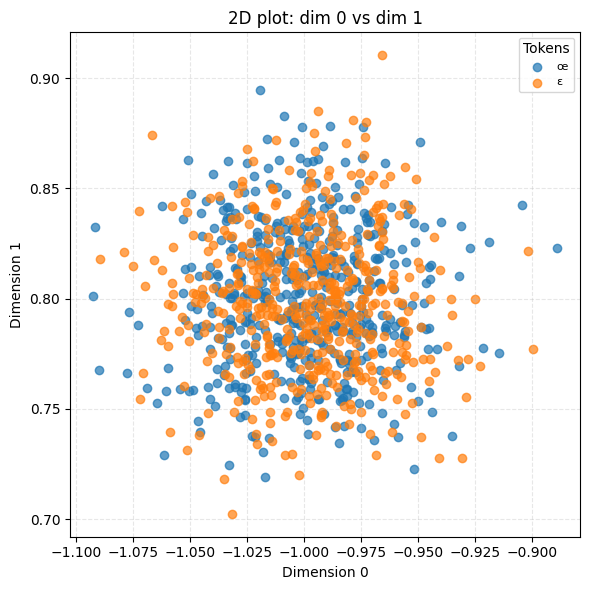

In [49]:
["i", "ɯ", "ɛ", "ʌ", "y", "u", "œ", "ɔ"]
data_selected, labels_selected, _ = select_tokens(data_test, labels_test, target_tokens=["œ", "ɛ"])
plot_tokens_2d(data_selected, labels_selected, dim_x=0, dim_y=1)

#### Training

In [66]:
# set parameters
num_samples = sum(sizes_train)
epochs = 10000
lr = 0.01
reg_param = 0
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()
z_data = torch.from_numpy(np.array(
    [
        [10.0, 0.0, 0.0, 0.0],
        [-10.0, 0.0, 0.0, 0.0],
        [0.0, 10.0, 0.0, 0.0],
        [0.0, -10.0, 0.0, 0.0],
        [0.0, 0.0, 10.0, 0.0],
        [0.0, 0.0, -10.0, 0.0],
        [0.0, 0.0, 0.0, 10.0],
        [0.0, 0.0, 0.0, -10.0]
    ]
)).float()  # for testing
z_labels = np.array(
    [
        '1+', '1-',
        '2+', '2-',
        '3+', '3-',
        '4+', '4-'
    ]
)

# set seed
np.random.seed(123)
torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):
t = 1
laeModel = LinearAutoEncoder()
laeModel.train(input_data, None, input_dim=4, 
                n_epoch=epochs, hidden_dim=hidden_dim, 
                learning_rate=lr, reg_param=reg[t], 
                noise='Gaussian', noise_scale=var[t], verbose=True, 
                Y=torch.from_numpy(data_test).float(), 
                Y_val=labels_test, 
                Z=z_data,
                Z_val=z_labels)
recorded_models.append(laeModel)

iteration:  0 training loss:  tensor(0.8429, device='cuda:0')
iteration:  100 training loss:  tensor(0.8429, device='cuda:0')
iteration:  200 training loss:  tensor(0.8429, device='cuda:0')
iteration:  300 training loss:  tensor(0.8429, device='cuda:0')
iteration:  400 training loss:  tensor(0.8429, device='cuda:0')
iteration:  500 training loss:  tensor(0.8429, device='cuda:0')
iteration:  600 training loss:  tensor(0.8428, device='cuda:0')
iteration:  700 training loss:  tensor(0.8418, device='cuda:0')
iteration:  800 training loss:  tensor(0.8351, device='cuda:0')
iteration:  900 training loss:  tensor(0.7897, device='cuda:0')
iteration:  1000 training loss:  tensor(0.5887, device='cuda:0')
iteration:  1100 training loss:  tensor(0.3708, device='cuda:0')
iteration:  1200 training loss:  tensor(0.3423, device='cuda:0')
iteration:  1300 training loss:  tensor(0.3404, device='cuda:0')
iteration:  1400 training loss:  tensor(0.3365, device='cuda:0')
iteration:  1500 training loss:  tens

Check how different PC dimensions work

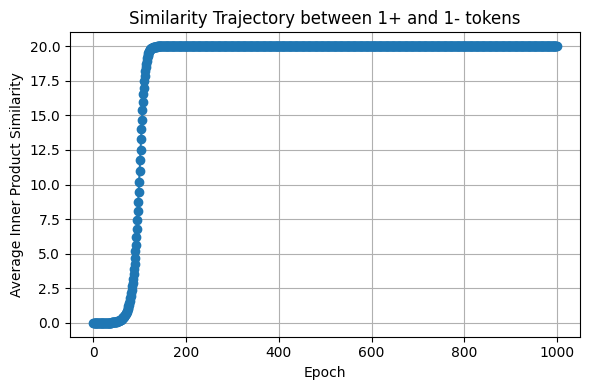

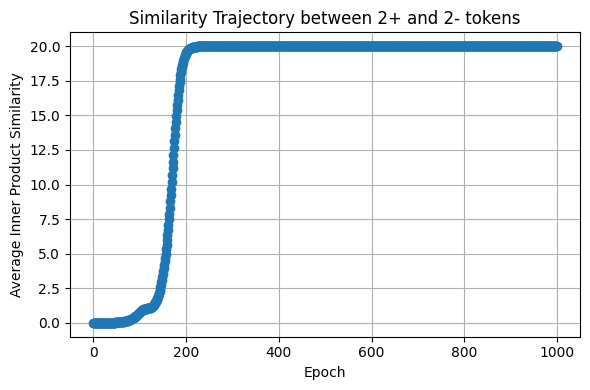

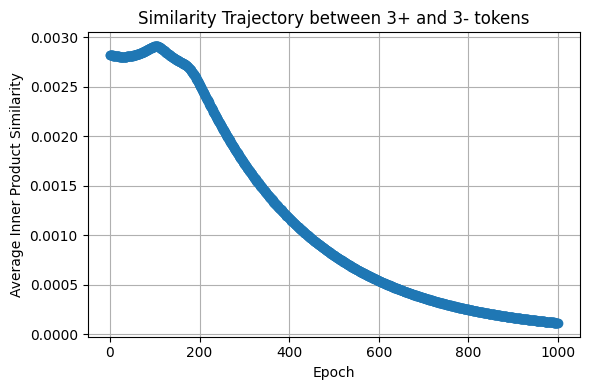

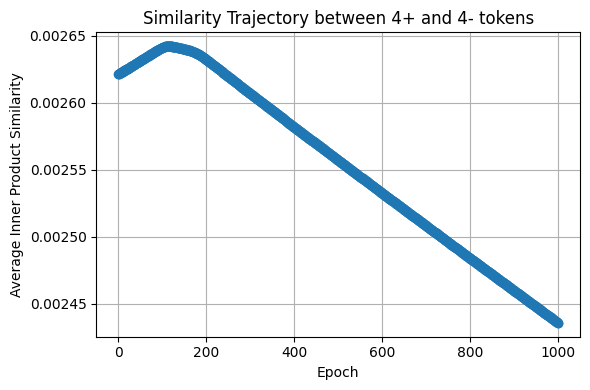

In [67]:
similarity_curves = {}
for contrast_pair in [("1+", "1-"), ("2+", "2-"), ("3+", "3-"), ("4+", "4-")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["z_testing_activations"], z_labels, label_a=label_a, label_b=label_b, 
                                                calculator=average_euclidean_distance)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Test Checking

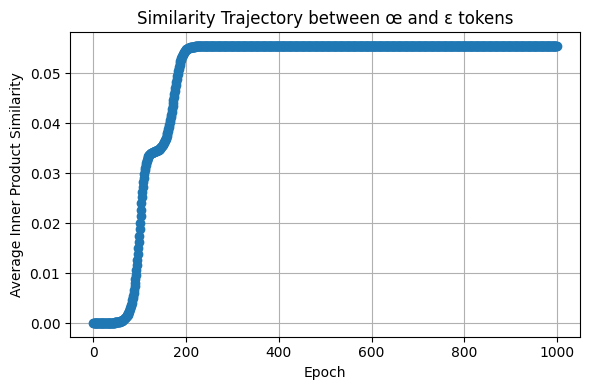

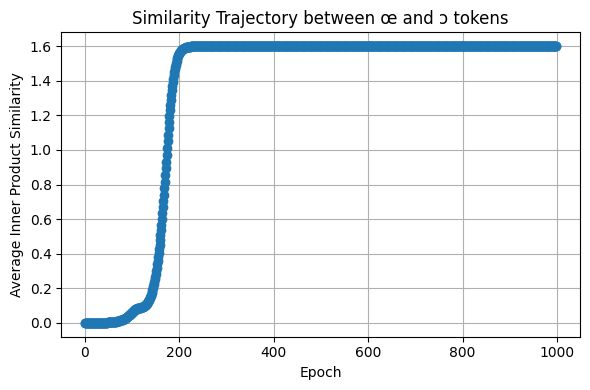

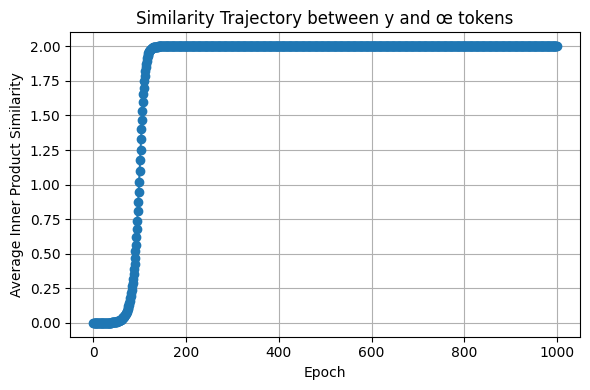

In [68]:
similarity_curves = {}
for contrast_pair in [("œ", "ɛ"), ("œ", "ɔ"), ("y", "œ")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["testing_activations"], labels_test, label_a=label_a, label_b=label_b, 
                                                calculator=average_euclidean_distance)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Beautified Visualization

('œ', 'ɛ'): (1000,)
('œ', 'ɔ'): (1000,)
('y', 'œ'): (1000,)
('i', 'ɯ'): (1000,)
('i', 'ɛ'): (1000,)


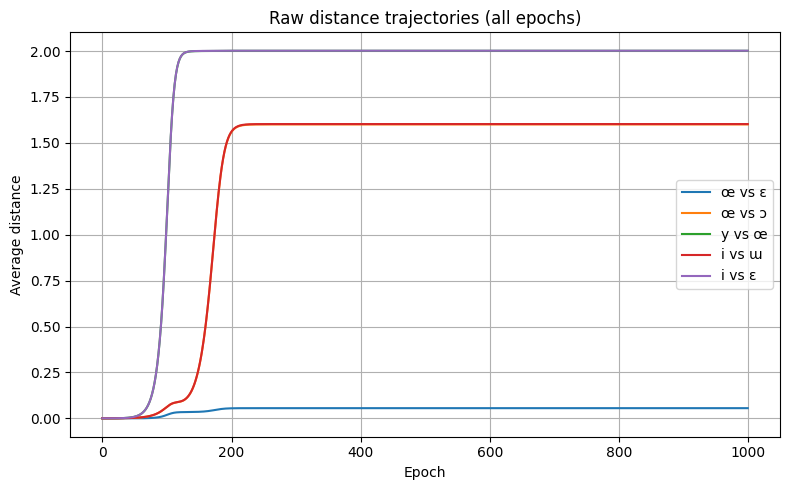

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Define the contrasts you want to include (native + others)
contrast_list = [("œ", "ɛ"), ("œ", "ɔ"), ("y", "œ"), ("i", "ɯ"), ("i", "ɛ")]

# Initialize storage
raw_curves = {}  # maps (label_a, label_b) → np.array of distances per epoch

# Iterate over contrasts and compute full trajectories
for label_a, label_b in contrast_list:
    similarity_curve = similarity_trajectory(
        recorded_models[0].history["testing_activations"],
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    raw_curves[(label_a, label_b)] = np.array(similarity_curve)

# Verify shape
for pair, curve in raw_curves.items():
    print(f"{pair}: {curve.shape}")

# (Optional quick check)
plt.figure(figsize=(8,5))
for (label_a, label_b), curve in raw_curves.items():
    plt.plot(curve, label=f"{label_a} vs {label_b}")
plt.xlabel("Epoch")
plt.ylabel("Average distance")
plt.title("Raw distance trajectories (all epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


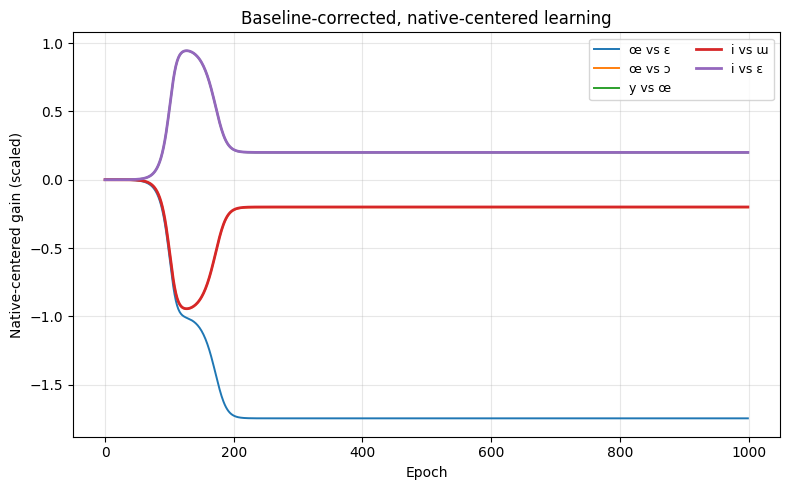

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# --- inputs you already have ---
# raw_curves: dict[(label_a,label_b)] -> np.array(T,)  # distance per epoch (e.g., avg Euclidean)
native_pairs = {("i", "ɯ"), ("i", "ɛ")}  # set of trained/native contrasts
T = next(iter(raw_curves.values())).shape[0]
eps = 1e-12

# Split keys
all_keys = list(raw_curves.keys())
nat_keys = [k for k in all_keys if k in native_pairs]
non_keys = [k for k in all_keys if k not in native_pairs]

# Stack
M_all = np.stack([raw_curves[k] for k in all_keys], axis=0)   # (C,T)
M_nat = np.stack([raw_curves[k] for k in nat_keys], axis=0)   # (Cnat,T)

# ---------- 1) Native-Centered Gain ----------
# change from own start
chg_all = M_all - M_all[:, [0]]          # (C,T)
chg_nat = M_nat - M_nat[:, [0]]          # (Cnat,T)
nat_mean_chg = chg_nat.mean(axis=0)      # (T,)

NCG = chg_all - nat_mean_chg             # broadcast (C,T)
NCG_star = NCG / (nat_mean_chg + eps)    # optional unitless version

ncg = {k: NCG[i] for i,k in enumerate(all_keys)}
ncg_star = {k: NCG_star[i] for i,k in enumerate(all_keys)}

# ---------- 2) Centered RDI ----------
mean_t = M_all.mean(axis=0)              # (T,)
cRDI = (M_all / (mean_t + eps)) - 1.0
crdi = {k: cRDI[i] for i,k in enumerate(all_keys)}

# ---------- 3) Native-z ----------
mu_nat = M_nat.mean(axis=0)              # (T,)
sd_nat = M_nat.std(axis=0)               # (T,)
Nz = (M_all - mu_nat) / (sd_nat + eps)
nz = {k: Nz[i] for i,k in enumerate(all_keys)}

# ---------- 4) Minus-native ----------
mu_nat = M_nat.mean(axis=0)              # (T,) mean of native contrasts per epoch
SubMean = M_all - mu_nat                 # subtract native mean at each epoch
submean = {k: SubMean[i] for i, k in enumerate(all_keys)}

# ---------- quick visualization: NCG* ----------
plt.figure(figsize=(8,5))
for k in all_keys:
    curve = submean[k][:2000]   # choose ncg, ncg_star, crdi, or nz
    lbl = f"{k[0]} vs {k[1]}"
    lw  = 2.0 if k in native_pairs else 1.4
    plt.plot(curve, label=lbl, linewidth=lw)
# plt.axhline(0.0, ls="--", c="k", label="native mean growth")
plt.xlabel("Epoch"); plt.ylabel("Native-centered gain (scaled)")
plt.title("Baseline-corrected, native-centered learning")
plt.legend(ncol=2, fontsize=9); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


#### Some More Methods

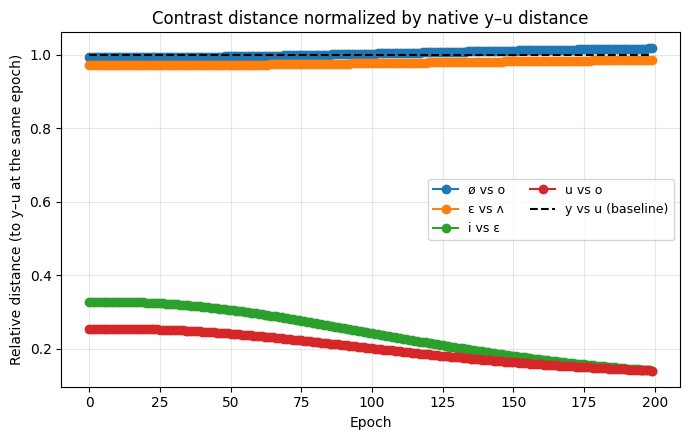

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the native pair used for training
native_pair = ("y", "u")

# Compute the native baseline curve (per-epoch)
native_curve = similarity_trajectory(
    recorded_models[0].history["testing_activations"],
    labels_test,
    label_a=native_pair[0],
    label_b=native_pair[1],
    calculator=average_euclidean_distance
)
native_curve = np.array(native_curve)

# Small epsilon to avoid division by zero
eps = 1e-12
denom = np.maximum(native_curve, eps)

# Define the other contrasts to compare (skip the native pair)
contrast_list = [("ø", "o"), ("ɛ", "ʌ"), ("i", "ɛ"), ("y", "u"), ("u", "o")]
contrast_list = [p for p in contrast_list if p != native_pair]

# Compute and store normalized curves
relative_curves = {}   # maps contrast -> normalized np.array
raw_curves = {}        # optional: keep raw for reference
for label_a, label_b in contrast_list:
    curve = similarity_trajectory(
        recorded_models[0].history["testing_activations"],
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    curve = np.array(curve)
    raw_curves[(label_a, label_b)] = curve
    relative_curves[(label_a, label_b)] = curve / denom  # elementwise normalization

# Optional: normalized native curve is identically 1
ones_native = np.ones_like(denom)

# -------- Plot all normalized curves together --------
max_epoch = 200
plt.figure(figsize=(7, 4.5))
for (label_a, label_b), rel_curve in relative_curves.items():
    plt.plot(rel_curve[:max_epoch], marker='o', linewidth=1.5, label=f"{label_a} vs {label_b}")

# Add the native baseline as a flat line at 1
plt.plot(ones_native[:max_epoch], linestyle='--', linewidth=1.5, color='k', label=f"{native_pair[0]} vs {native_pair[1]} (baseline)")

plt.xlabel("Epoch")
plt.ylabel("Relative distance (to y–u at the same epoch)")
plt.title("Contrast distance normalized by native y–u distance")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# -------- If you still want per-contrast figures (normalized), uncomment: --------
# for (label_a, label_b), rel_curve in relative_curves.items():
#     plt.figure(figsize=(6, 4))
#     plt.plot(rel_curve, marker='o')
#     plt.plot(ones_native, linestyle='--', color='k')
#     plt.xlabel("Epoch")
#     plt.ylabel("Relative distance (to y–u at the same epoch)")
#     plt.title(f"Relative trajectory: {label_a} vs {label_b}")
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()


##### RDI

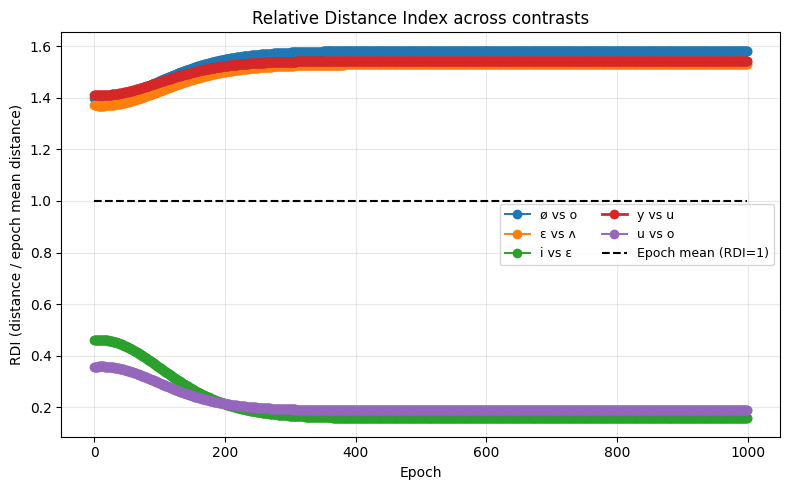

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the native pair used for training
native_pair = ("y", "u")

# Define the contrasts to include in the RDI pool (include the native pair)
contrast_list = [("ø", "o"), ("ɛ", "ʌ"), ("i", "ɛ"), ("y", "u"), ("u", "o")]
# Make sure native is present once
if native_pair not in contrast_list:
    contrast_list = [native_pair] + contrast_list

# Collect raw distance curves for all contrasts
raw_curves = {}  # (label_a, label_b) -> np.array(T,)
for label_a, label_b in contrast_list:
    curve = similarity_trajectory(
        recorded_models[0].history["testing_activations"],
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    raw_curves[(label_a, label_b)] = np.array(curve)

# Stack to compute per-epoch mean across contrasts (RDI denominator)
all_curves = np.stack([raw_curves[k] for k in contrast_list], axis=0)  # shape (C, T)
eps = 1e-12
mean_per_epoch = np.mean(all_curves, axis=0)
denom = np.maximum(mean_per_epoch, eps)

# Compute RDI curves
rdi_curves = {k: v / denom for k, v in raw_curves.items()}  # elementwise normalization

# Plot
max_epoch = 10000
plt.figure(figsize=(8, 5))
for (label_a, label_b), rdi_curve in rdi_curves.items():
    lbl = f"{label_a} vs {label_b}"
    # highlight native pair
    if (label_a, label_b) == native_pair:
        plt.plot(rdi_curve[:max_epoch], marker='o', linewidth=2.0, label=lbl)
    else:
        plt.plot(rdi_curve[:max_epoch], marker='o', linewidth=1.4, label=lbl)

# Flat reference at 1 (by definition of RDI)
plt.plot(np.ones_like(denom[:max_epoch]), linestyle='--', linewidth=1.5, color='k', label="Epoch mean (RDI=1)")

plt.xlabel("Epoch")
plt.ylabel("RDI (distance / epoch mean distance)")
plt.title("Relative Distance Index across contrasts")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


('ø', 'o'): (1000,)
('ɛ', 'ʌ'): (1000,)
('i', 'ɛ'): (1000,)
('y', 'u'): (1000,)
('u', 'o'): (1000,)


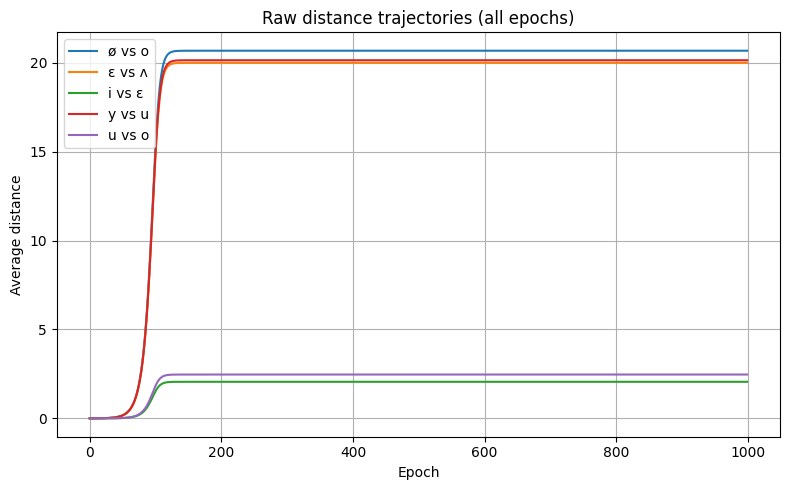

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Define the contrasts you want to include (native + others)
contrast_list = [("ø", "o"), ("ɛ", "ʌ"), ("i", "ɛ"), ("y", "u"), ("u", "o")]

# Initialize storage
raw_curves = {}  # maps (label_a, label_b) → np.array of distances per epoch

# Iterate over contrasts and compute full trajectories
for label_a, label_b in contrast_list:
    similarity_curve = similarity_trajectory(
        recorded_models[0].history["testing_activations"],
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    raw_curves[(label_a, label_b)] = np.array(similarity_curve)

# Verify shape
for pair, curve in raw_curves.items():
    print(f"{pair}: {curve.shape}")

# (Optional quick check)
plt.figure(figsize=(8,5))
for (label_a, label_b), curve in raw_curves.items():
    plt.plot(curve, label=f"{label_a} vs {label_b}")
plt.xlabel("Epoch")
plt.ylabel("Average distance")
plt.title("Raw distance trajectories (all epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


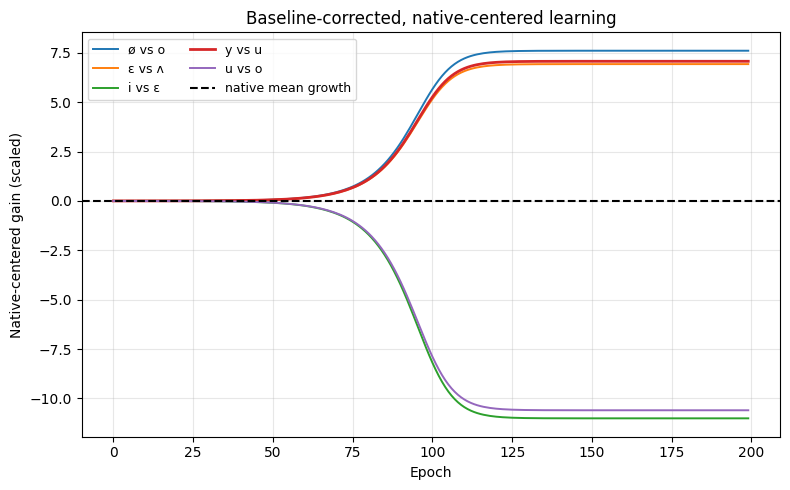

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# --- inputs you already have ---
# raw_curves: dict[(label_a,label_b)] -> np.array(T,)  # distance per epoch (e.g., avg Euclidean)
native_pairs = {("y","u")}  # set of trained/native contrasts
T = next(iter(raw_curves.values())).shape[0]
eps = 1e-12

# Split keys
all_keys = list(raw_curves.keys())
nat_keys = [k for k in all_keys if k in native_pairs]
non_keys = [k for k in all_keys if k not in native_pairs]

# Stack
M_all = np.stack([raw_curves[k] for k in all_keys], axis=0)   # (C,T)
M_nat = np.stack([raw_curves[k] for k in nat_keys], axis=0)   # (Cnat,T)

# ---------- 1) Native-Centered Gain ----------
# change from own start
chg_all = M_all - M_all[:, [0]]          # (C,T)
chg_nat = M_nat - M_nat[:, [0]]          # (Cnat,T)
nat_mean_chg = chg_nat.mean(axis=0)      # (T,)

NCG = chg_all - nat_mean_chg             # broadcast (C,T)
NCG_star = NCG / (nat_mean_chg + eps)    # optional unitless version

ncg = {k: NCG[i] for i,k in enumerate(all_keys)}
ncg_star = {k: NCG_star[i] for i,k in enumerate(all_keys)}

# ---------- 2) Centered RDI ----------
mean_t = M_all.mean(axis=0)              # (T,)
cRDI = (M_all / (mean_t + eps)) - 1.0
crdi = {k: cRDI[i] for i,k in enumerate(all_keys)}

# ---------- 3) Native-z ----------
mu_nat = M_nat.mean(axis=0)              # (T,)
sd_nat = M_nat.std(axis=0)               # (T,)
Nz = (M_all - mu_nat) / (sd_nat + eps)
nz = {k: Nz[i] for i,k in enumerate(all_keys)}

# ---------- 4) Minus-native ----------
mu_nat = M_all.mean(axis=0)              # (T,) mean of native contrasts per epoch
SubMean = M_all - mu_nat                 # subtract native mean at each epoch
submean = {k: SubMean[i] for i, k in enumerate(all_keys)}

# ---------- quick visualization: NCG* ----------
plt.figure(figsize=(8,5))
for k in all_keys:
    curve = submean[k][:200]   # choose ncg, ncg_star, crdi, or nz
    lbl = f"{k[0]} vs {k[1]}"
    lw  = 2.0 if k in native_pairs else 1.4
    plt.plot(curve, label=lbl, linewidth=lw)
plt.axhline(0.0, ls="--", c="k", label="native mean growth")
plt.xlabel("Epoch"); plt.ylabel("Native-centered gain (scaled)")
plt.title("Baseline-corrected, native-centered learning")
plt.legend(ncol=2, fontsize=9); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [155]:
similarity_curves.keys()

dict_keys([('ø', 'o'), ('ɛ', 'ʌ'), ('i', 'ɛ'), ('y', 'u'), ('u', 'o')])

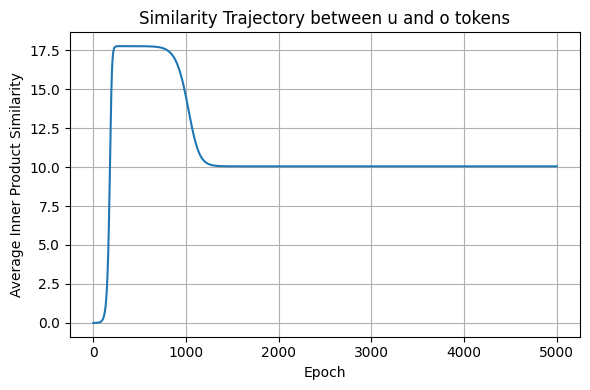

In [156]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[('y', 'u')] - similarity_curves[('i', 'ɛ')])[:])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

#### End of Organized Simulations

### Case 3: Multiple contrast one large one small

#### Data

In [73]:
# training means and shared std
means_train = [
    np.array([0.0, 0.0, -10.0, -2.5]),  # /y/
    np.array([0.0, 0.0, -10.0, 2.5]),  # /i/
    np.array([0.0, 0.0, 10.0, -2.5]),  # /u/
    np.array([0.0, 0.0, 10.0, 2.5]),  # /uu/
]
var_strength = 5.0  # Hz in all dimensions
vars_train = [var_strength] * len(means_train)
sizes_train = [100 // len(means_train)] * len(means_train)  # for example
tags_train = ["y", "i", "u", "uu"] # , "ø", "o"

means_test = [
    np.array([0.0, 5.0, -10.0, -2.5]),  # /ø/
    np.array([0.0, 5.0, -10.0, 2.5]),  # /e/
    np.array([0.0, 5.0, 10.0, -2.5]),  # /o/
    np.array([0.0, 10.0, -10.0, 2.5]),  # /ɛ/
    np.array([0.0, 10.0, 10.0, 2.5]),  # /ʌ/
    np.array([0.0, 10.0, 10.0, -2.5]),  # /c/
    np.array([0.0, 0.0, -10.0, 2.5]),  # /i/
    np.array([0.0, 0.0, -10.0, -2.5]),  # /y/
    np.array([0.0, 0.0, 10.0, -2.5]),  # /u/
     np.array([0.0, 0.0, 10.0, 2.5]), # /uu/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [50] * len(means_test)  # for example
tags_test = ["ø", "e", "o", "ɛ", "ʌ", "c", "i", "y", "u", "uu"]

data_train, labels_train = generate_gmm_data(d=4, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=4, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

#### Debuggings

In [254]:
corr_mat = compute_correlation_matrix(data_train, data_train)
U, S, V = np.linalg.svd(corr_mat)

In [255]:
S

array([9648.60519989, 1145.8536813 ,  571.26165087,  446.87115715])

In [256]:
C = np.cov(data_train, rowvar=False)
U_, S_, Vt_ = np.linalg.svd(C)

In [257]:
U @ np.array([1, 0, 0, 0])

array([-0.0394741 , -0.00496212,  0.99875795, -0.02999537])

In [258]:
U

array([[-0.0394741 ,  0.04676956, -0.92926813, -0.3643009 ],
       [-0.00496212, -0.07510977,  0.36085363, -0.92957978],
       [ 0.99875795, -0.02842738, -0.03703153, -0.01740975],
       [-0.02999537, -0.99567214, -0.06981453,  0.05350882]])

In [259]:
U @ np.array([1, 0, 0, 0]), U @ np.array([-1, 0, 0, 0])

(array([-0.0394741 , -0.00496212,  0.99875795, -0.02999537]),
 array([ 0.0394741 ,  0.00496212, -0.99875795,  0.02999537]))

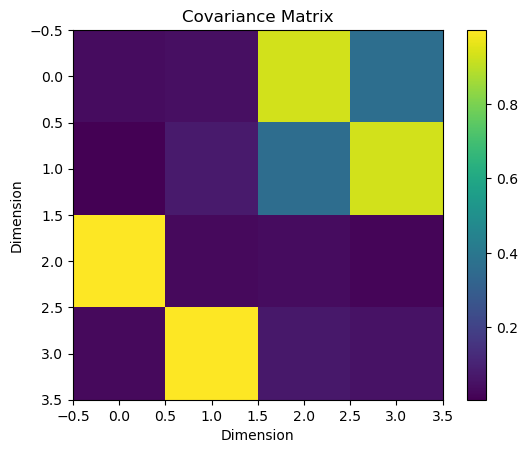

In [260]:
plt.figure()
plt.imshow(abs(U), aspect='equal')
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Dimension")
plt.ylabel("Dimension")
plt.show()

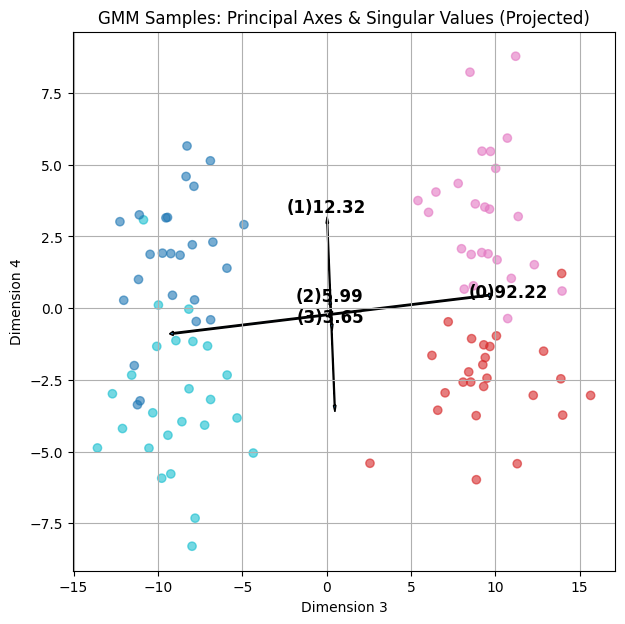

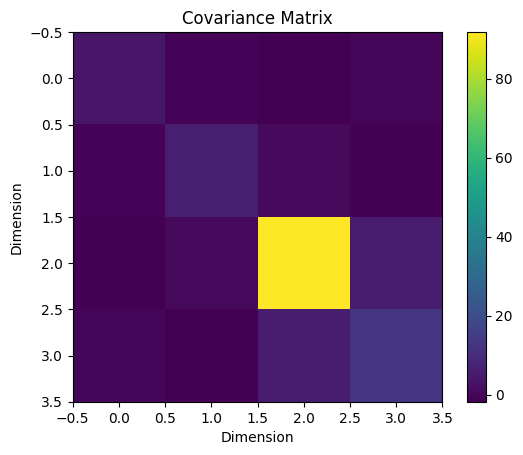

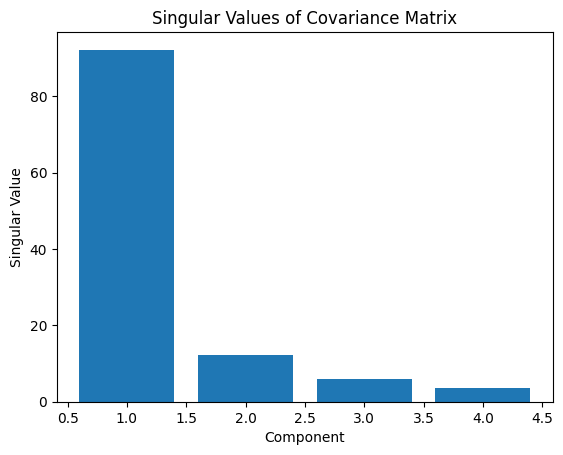

In [74]:
plot_2d_projection_with_principal_axes(data_train, labels_train, dim_x=2, dim_y=3)

#### Pre-training Test

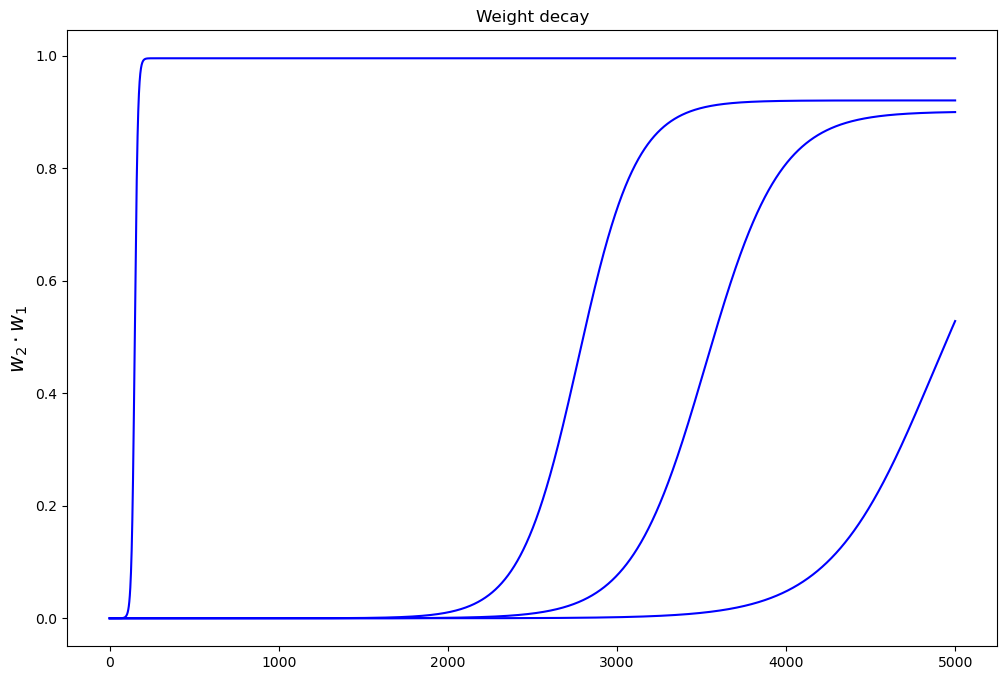

In [ ]:
# set parameters
num_samples = sum(sizes_train)
epochs = 5000
lr = 0.0005
reg_param = 0.5
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()

# set seed
np.random.seed(123)
torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):

# create dynamics plot
slices = (0, 1, 2, 3)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8), sharey='row', sharex='col')
# axes = [ax1, ax2]

w0 = 1e-7
theoretical_dynamics_reg = theoretical_learning_dynamics(
                                data_train, 
                                data_train, 
                                n_epoch=epochs, lr=lr, var=0, 
                                reg=reg_param, u0 = w0)

# plot simulated dynamics
x_p = np.arange(0, epochs+1, 1)
rangestart = 0
ax1.plot(theoretical_dynamics_reg[:, slices], c='blue', 
         label='Theory ($\gamma = 0$)')
    
    
# set plot titles and axis labels
ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)
ax1.set_title('Weight decay')
# ax2.yaxis.set_label_position('right')
# ax2.set_ylabel('MNIST')
plt.show()

#### Training

In [75]:
# set parameters
num_samples = sum(sizes_train)
epochs = 10000
lr = 0.001
reg_param = 0.5
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()
z_data = torch.from_numpy(np.array(
    [
        [10.0, 0.0, 0.0, 0.0],
        [-10.0, 0.0, 0.0, 0.0],
        [0.0, 10.0, 0.0, 0.0],
        [0.0, -10.0, 0.0, 0.0],
        [0.0, 0.0, 10.0, 0.0],
        [0.0, 0.0, -10.0, 0.0],
        [0.0, 0.0, 0.0, 10.0],
        [0.0, 0.0, 0.0, -10.0]
    ]
)).float()  # for testing
z_labels = np.array(
    [
        '1+', '1-',
        '2+', '2-',
        '3+', '3-',
        '4+', '4-'
    ]
)

# set seed
np.random.seed(123)
torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):
t = 1
laeModel = LinearAutoEncoder()
laeModel.train(input_data, None, input_dim=4, 
                n_epoch=epochs, hidden_dim=hidden_dim, 
                learning_rate=lr, reg_param=reg[t], 
                noise='Gaussian', noise_scale=var[t], verbose=True, 
                Y=torch.from_numpy(data_test).float(), 
                Y_val=labels_test, 
                Z=z_data,
                Z_val=z_labels)
recorded_models.append(laeModel)

iteration:  0 training loss:  tensor(56.6479, device='cuda:0')
iteration:  100 training loss:  tensor(47.1877, device='cuda:0')
iteration:  200 training loss:  tensor(11.4688, device='cuda:0')
iteration:  300 training loss:  tensor(11.4687, device='cuda:0')
iteration:  400 training loss:  tensor(11.4671, device='cuda:0')
iteration:  500 training loss:  tensor(11.4510, device='cuda:0')
iteration:  600 training loss:  tensor(11.2870, device='cuda:0')
iteration:  700 training loss:  tensor(9.9325, device='cuda:0')
iteration:  800 training loss:  tensor(6.5323, device='cuda:0')
iteration:  900 training loss:  tensor(5.8333, device='cuda:0')
iteration:  1000 training loss:  tensor(5.8201, device='cuda:0')
iteration:  1100 training loss:  tensor(5.8199, device='cuda:0')
iteration:  1200 training loss:  tensor(5.8199, device='cuda:0')
iteration:  1300 training loss:  tensor(5.8199, device='cuda:0')
iteration:  1400 training loss:  tensor(5.8199, device='cuda:0')
iteration:  1500 training loss

In [250]:
def average_inner_product(X1, X2):
    # X1, X2: arrays of shape (N1, D), (N2, D)
    # Compute inner products for all pairs, return the mean
    ip = np.dot(X1, X2.T)  # shape (N1, N2)
    return ip.mean()

def average_cosine_similarity(A, B):
    """
    Computes cosine similarity between all pairs of rows in A (N1, D) and B (N2, D)
    Returns an (N1, N2) matrix of similarities.
    """
    # Normalize each row to unit length
    A_norm = A / np.linalg.norm(A, axis=1, keepdims=True)
    B_norm = B / np.linalg.norm(B, axis=1, keepdims=True)
    # Compute cosine similarity as dot product
    sim_matrix = np.dot(A_norm, B_norm.T)
    return sim_matrix.mean()  # shape (N1, N2)

def average_euclidean_distance(A, B):
    """
    Returns the matrix of Euclidean distances between all pairs in A (N1, D) and B (N2, D)
    Output: (N1, N2)
    """
    # Efficient computation: (a - b)^2 = a^2 + b^2 - 2ab
    A_sq = np.sum(A**2, axis=1, keepdims=True)  # (N1, 1)
    B_sq = np.sum(B**2, axis=1, keepdims=True).T  # (1, N2)
    cross = np.dot(A, B.T)  # (N1, N2)
    dist_sq = A_sq + B_sq - 2 * cross
    dist_sq = np.maximum(dist_sq, 0.0)  # for numerical safety
    distances = np.sqrt(dist_sq)
    return distances.mean()  # shape (N1, N2)

def similarity_trajectory(recon_test, labels_test, label_a, label_b, calculator=average_inner_product):
    sims = []
    for epoch_data in recon_test:  # each is (N_test, D)
        idx_a = np.where(labels_test == label_a)[0]
        idx_b = np.where(labels_test == label_b)[0]
        X_a = epoch_data[idx_a]
        X_b = epoch_data[idx_b]
        sim = calculator(X_a, X_b)
        sims.append(sim)
    return sims

def similarity_trajectory_normalized(recon_test, ori_test, labels_test, label_a, label_b, calculator=average_inner_product):
    sims = []
    for epoch_data in recon_test:  # each is (N_test, D)
        idx_a = np.where(labels_test == label_a)[0]
        idx_b = np.where(labels_test == label_b)[0]
        X_a = epoch_data[idx_a]
        X_b = epoch_data[idx_b]
        sim = calculator(X_a, X_b)

        ori_sim = calculator(ori_test[idx_a], ori_test[idx_b])
        norm_sim = sim / ori_sim if ori_sim != 0 else 0
        sims.append(norm_sim)
    return sims

#### Principle Direction Contrast

- Interim conclusion: if we only have this one contrast, it is still very safe, and it will be learned as well. However, if variance is too large or if this contrast is embedded in a larger language with multiple contrasts that are much more salient, it will be hard to learn. 

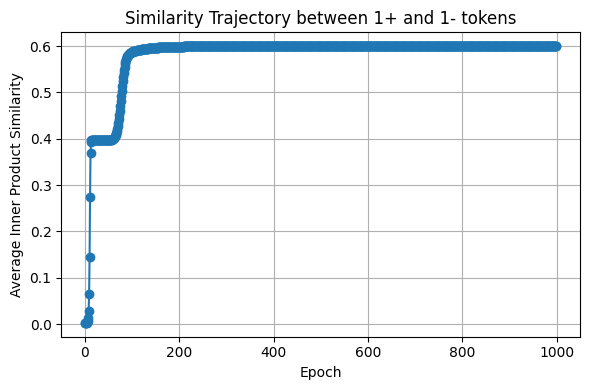

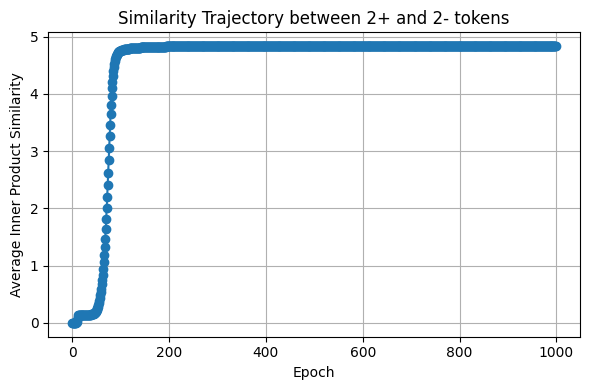

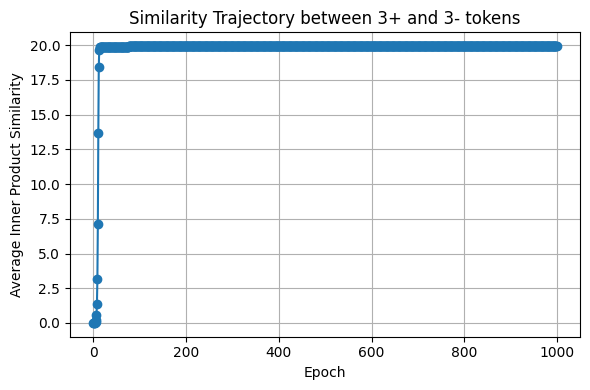

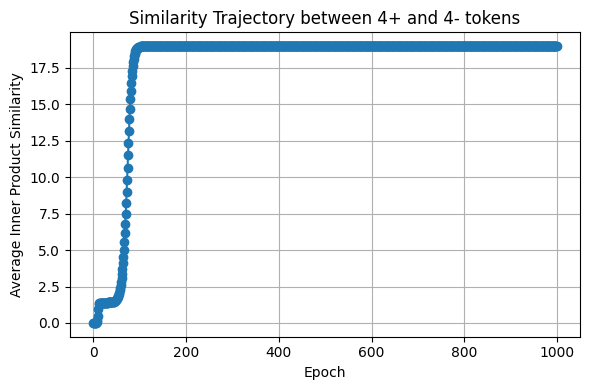

In [76]:
similarity_curves = {}
for contrast_pair in [("1+", "1-"), ("2+", "2-"), ("3+", "3-"), ("4+", "4-")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["z_testing_activations"], z_labels, label_a=label_a, label_b=label_b, 
                                                calculator=average_euclidean_distance)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Mock Vowel Contrast

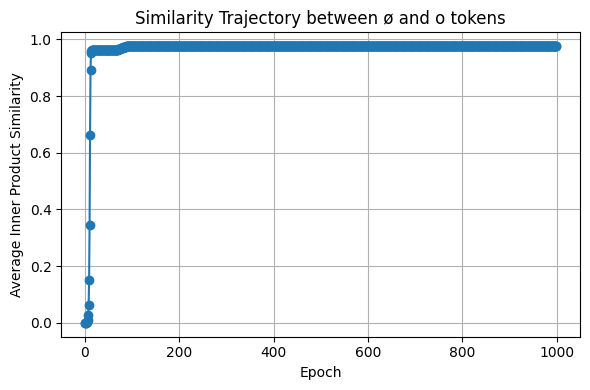

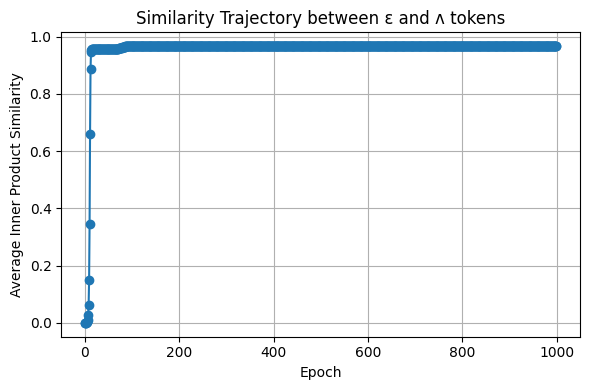

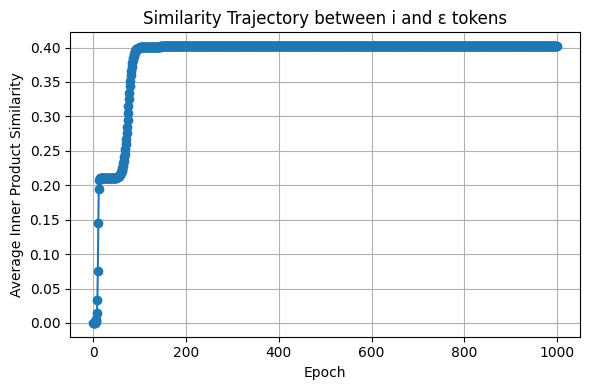

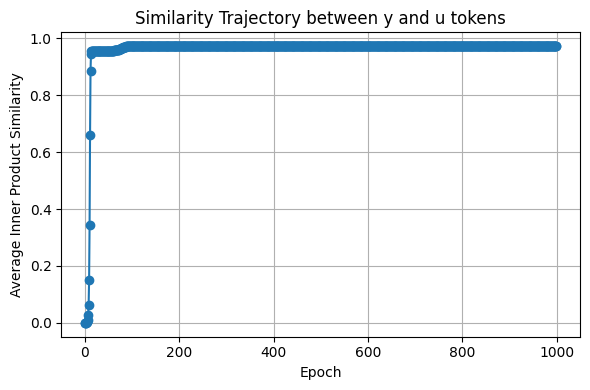

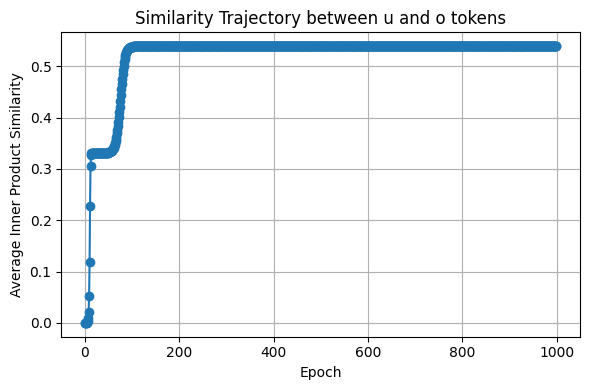

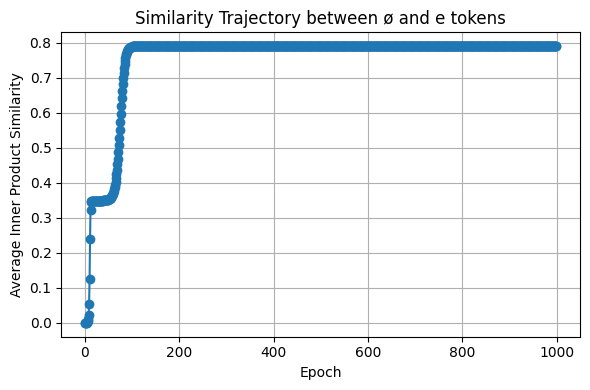

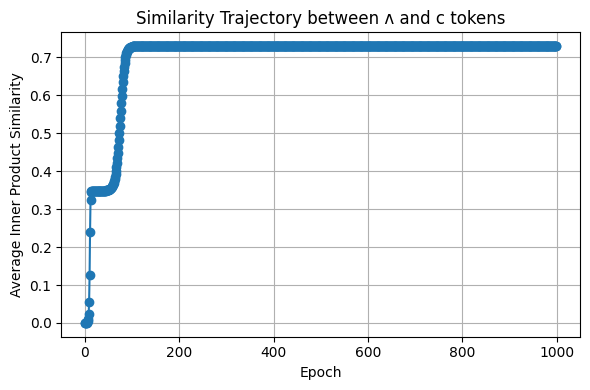

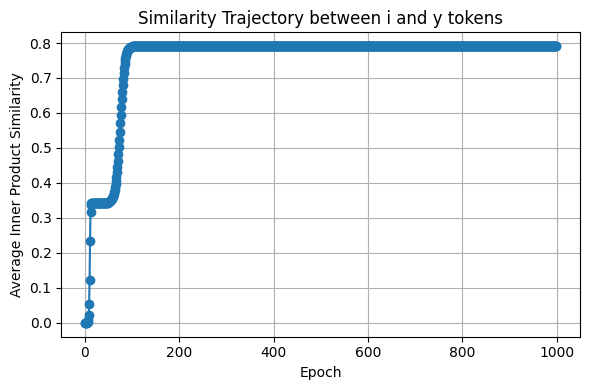

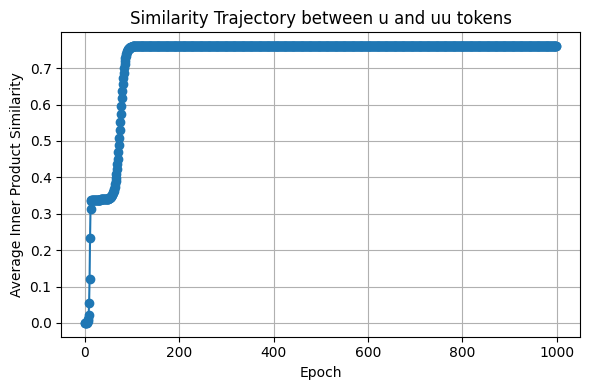

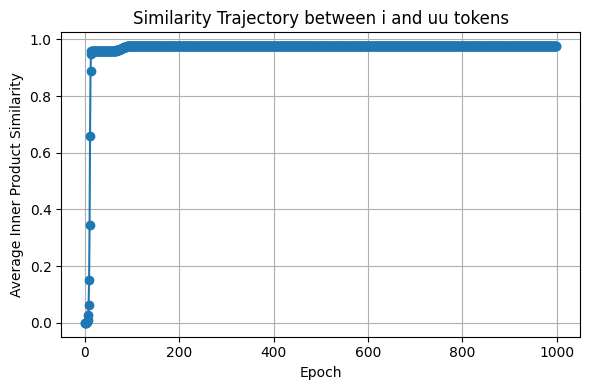

In [80]:
similarity_curves = {}
for contrast_pair in [("ø", "o"), ("ɛ", "ʌ"), ("i", "ɛ"), ("y", "u"), ("u", "o"), ("ø", "e"), ("ʌ", "c"), ("i", "y"), ("u", "uu"), ("i", "uu")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory_normalized(recorded_models[0].history["testing_activations"], data_test, labels_test, label_a=label_a, label_b=label_b, 
                                                calculator=average_euclidean_distance)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [278]:
similarity_curves.keys()

dict_keys([('ø', 'o'), ('ɛ', 'ʌ'), ('i', 'ɛ'), ('y', 'u'), ('u', 'o'), ('ø', 'e'), ('ʌ', 'c'), ('i', 'y'), ('u', 'uu'), ('i', 'uu')])

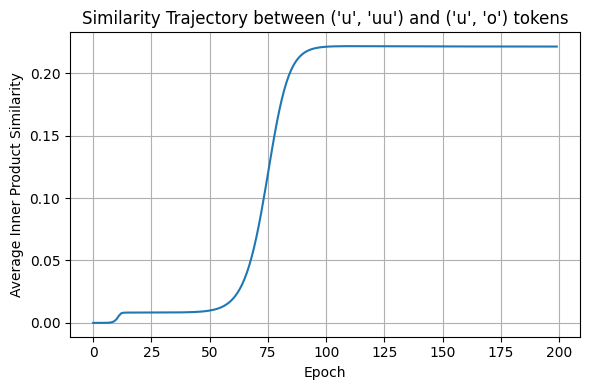

In [81]:
native_pair = ('u', 'uu')
foreign_pair = ('u', 'o')
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[native_pair] - similarity_curves[foreign_pair])[:200])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {native_pair} and {foreign_pair} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

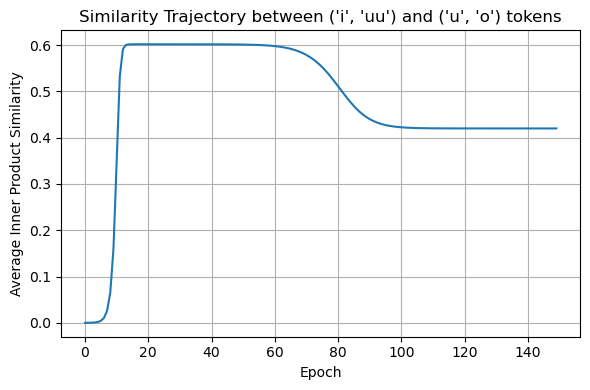

In [283]:
native_pair = ('i', 'uu')
foreign_pair = ('u', 'o')
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[native_pair] - similarity_curves[foreign_pair])[:150])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {native_pair} and {foreign_pair} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

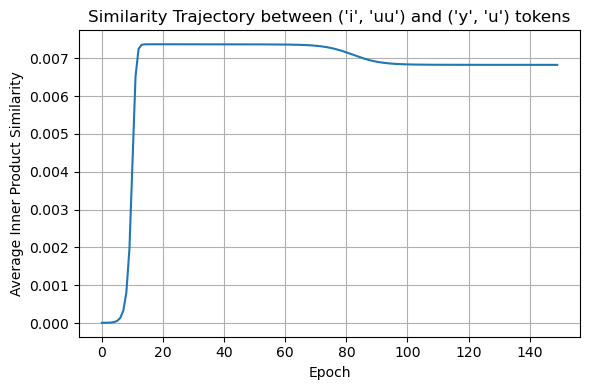

In [284]:
native_pair = ('i', 'uu')
foreign_pair = ('y', 'u')
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[native_pair] - similarity_curves[foreign_pair])[:150])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {native_pair} and {foreign_pair} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

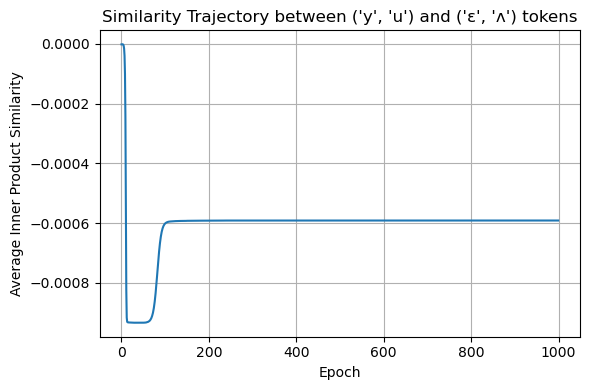

In [291]:
native_pair = ('y', 'u')
foreign_pair = ('ɛ', 'ʌ')
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[native_pair] - similarity_curves[foreign_pair])[:])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {native_pair} and {foreign_pair} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Interim Conclusions
1. The larger the contrast, the faster it is learned. And the better it is learned finally. 
2. Under current learning mechanisms, contrasts following the same trajectory have no difference in distinguishing. However, contrasts vertical to the L1 contrasts would not be learned. 
3. Thus, the larger the contrast, the shorter the universal period. The smaller the contrast, the longer. 
4. What was not expected was that if hidden representation dimension number is smaller than input, those small dimensions that will not be learned FINALLY, will show small learning and then de-learning DURING the process. I am not sure how this can be explained theoretically, but the effect size seems small, yet we may find something from this. (This is not related to contrasts parallel to L1 contrast)
5. When the training size is large, and if all the data are drawn from the same underlying distribution, both repeated training and online learning would converge to the same learning outcome. This means that although we are using small training dataset and large repetitions, it would be okay because it is similar to online learning of the same number of training steps (if we ignore overfitting). 

#### Theoretical vs Simulation

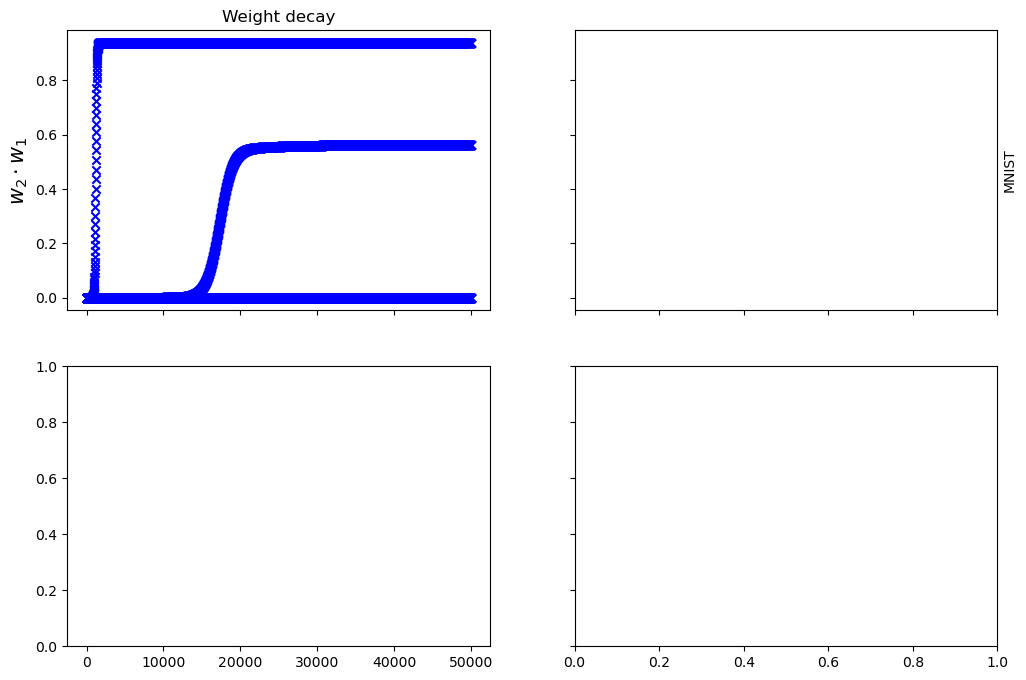

In [ ]:
# create dynamics plot
slices = (0, 1, 2, 3)
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(12, 8), sharey='row', sharex='col')
axes = [ax1, ax2]

# get actual dynamics
actual_dynamics_mnist = recorded_models[0].strenghts.cpu().numpy()
# actual_dynamics_reg_mnist = recorded_models[1].strenghts.cpu().numpy()
# actual_dynamics_mnist = recorded_models[0].history['weights']['W1']
# actual_dynamics_reg_mnist = recorded_models[1].history['weights']['W1']
# actual_dynamics_noise_mnist = mnist_models[2].strenghts.cpu().numpy()
w0 = recorded_models[0].init
theoretical_dynamics_reg = theoretical_learning_dynamics(
                                data_train, 
                                data_train, 
                                n_epoch=epochs, lr=lr, var=0, 
                                reg=reg_param, u0 = w0)

# # plot simulated dynamics
# x_p = np.arange(0, epochs+1, 1)
# rangestart = 0
# ax1.plot(theoretical_dynamics_reg[:, slices], c='blue', 
#          label='Theory ($\gamma = 0$)')

# plot simulated dynamics
x_p = np.arange(0, epochs+1, 10)
rangestart = 0
for s in slices:
    ax1.scatter(x_p[rangestart:], actual_dynamics_mnist[rangestart:, s], c='blue', 
                marker='x', label='Actual ($\gamma = 0$)')
    # ax1.scatter(x_p[rangestart:], actual_dynamics_reg_mnist[rangestart:, s], c='orange', 
    #             marker='x', label='Actual ($\gamma = $' + str(reg_param) + ')')
    # ax2.scatter(x_p, actual_dynamics_mnist[:, s], c='blue', 
    #             marker='x', label='Actual ($\sigma^2 = 0$)')
    # ax2.scatter(x_p, actual_dynamics_noise_mnist[:, s], c='darkgreen',
    #             marker='x', label='Actual ($\sigma^2 = $' + str(var_param) + ')')
    
    
# set plot titles and axis labels
ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)
ax1.set_title('Weight decay')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('MNIST')
plt.show()

In [ ]:
import numpy as np


# Helper functions to compute theoretical learning dynamics
def dae_learning_dynamics(lam, var, gamma, N, n_epoch, learning_rate, u0):
    dynamics = []
    tau = N/learning_rate
    g = N*gamma
    xi = lam + N*var
    
    for t in range(n_epoch):
        E = np.exp((2*(lam - g)*t)/tau)
        num = (lam - g)*E
        denom = xi*(E - 1) + (lam - g)/u0
        uf = num/denom
        dynamics.append(uf)
    
    return np.asarray(dynamics)
  
def compute_correlation_matrix(x, y):
    mat = np.zeros((y.shape[1], x.shape[1]))
    for x_vec, y_vec in zip(x, y):
        mat += np.outer(y_vec, x_vec)
    return mat
  
def theoretical_learning_dynamics(X, y, n_epoch, lr, var, reg, u0 = 2.5e-7):
    dyns = np.zeros((1,X.shape[1]))
    corr_mat = compute_correlation_matrix(X, y)
    U, S, V = np.linalg.svd(corr_mat)
    dyns = dae_learning_dynamics(S, var, reg, X.shape[0], n_epoch, lr, u0)
    return dyns

### Case 4: Small contrasts

In [159]:
# training means and shared std
means_train = [
    # np.array([120.0, 320.0, 1650.0, 2250.0]),  # /y/
    # np.array([120.0, 320.0,  800.0, 2250.0]),  # /u/
    np.array([0.0, 0.0, 0.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 0.0, 5.0]),  # /i/
]
var_strength = 5.0  # Hz in all dimensions
vars_train = [var_strength] * len(means_train)
sizes_train = [100 // len(means_train)] * len(means_train)  # for example
tags_train = ["y", "i"]

means_test = [
    np.array([0.0, 5.0, -10.0, 0.0]),  # /ø/
    np.array([0.0, 5.0, 10.0, 0.0]),  # /o/
    np.array([0.0, 10.0, -10.0, 5.0]),  # /ɛ/
    np.array([0.0, 10.0, 10.0, 5.0]),  # /ʌ/
    np.array([0.0, 0.0, -10.0, 5.0]),  # /i/
    np.array([0.0, 0.0, -10.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 10.0, 0.0]),  # /u/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [50] * len(means_test)  # for example
tags_test = ["ø", "o", "ɛ", "ʌ", "i", "y", "u"]

data_train, labels_train = generate_gmm_data(d=4, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=4, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

In [160]:
# set parameters
num_samples = sum(sizes_train)
epochs = 5000
lr = 0.001
reg_param = 0.5
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()

# set seed
# np.random.seed(123)
# torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):
t = 1
laeModel = LinearAutoEncoder()
laeModel.train(input_data, None, input_dim=4, 
                n_epoch=epochs, hidden_dim=hidden_dim, 
                learning_rate=lr, reg_param=reg[t], 
                noise='Gaussian', noise_scale=var[t], verbose=True, 
                Y=torch.from_numpy(data_test).float(), 
                Y_val=labels_test)
recorded_models.append(laeModel)

iteration:  0 training loss:  tensor(15.6311, device='cuda:0')
iteration:  100 training loss:  tensor(15.6311, device='cuda:0')
iteration:  200 training loss:  tensor(15.6311, device='cuda:0')
iteration:  300 training loss:  tensor(15.6308, device='cuda:0')
iteration:  400 training loss:  tensor(15.6228, device='cuda:0')
iteration:  500 training loss:  tensor(15.4473, device='cuda:0')
iteration:  600 training loss:  tensor(12.6771, device='cuda:0')
iteration:  700 training loss:  tensor(8.1602, device='cuda:0')
iteration:  800 training loss:  tensor(8.0268, device='cuda:0')
iteration:  900 training loss:  tensor(8.0264, device='cuda:0')
iteration:  1000 training loss:  tensor(8.0262, device='cuda:0')
iteration:  1100 training loss:  tensor(8.0254, device='cuda:0')
iteration:  1200 training loss:  tensor(8.0230, device='cuda:0')
iteration:  1300 training loss:  tensor(8.0151, device='cuda:0')
iteration:  1400 training loss:  tensor(7.9898, device='cuda:0')
iteration:  1500 training loss

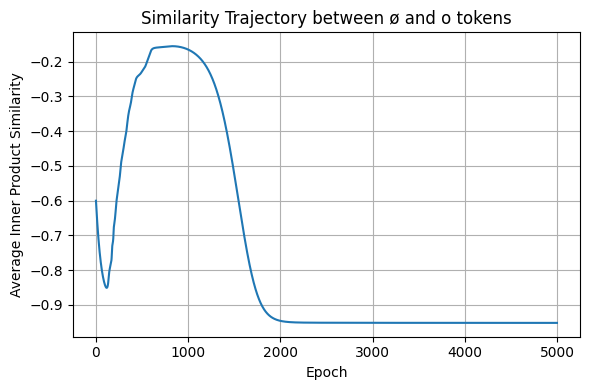

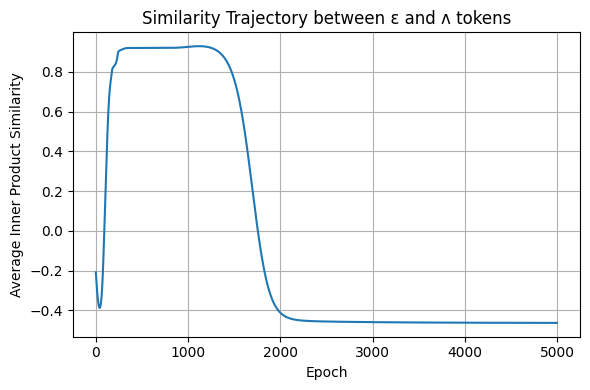

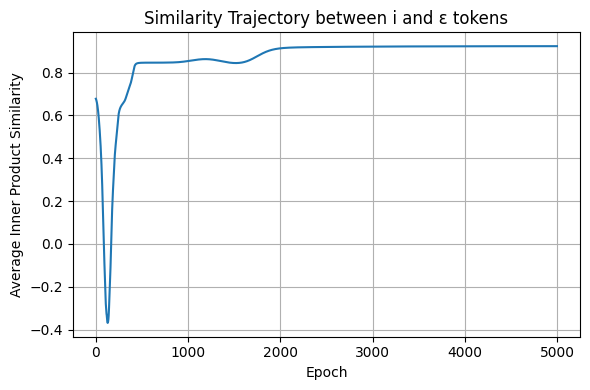

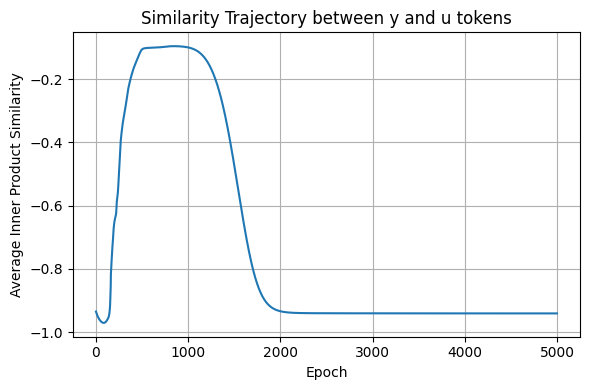

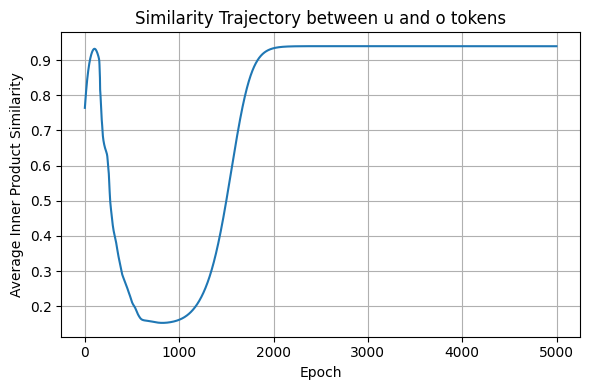

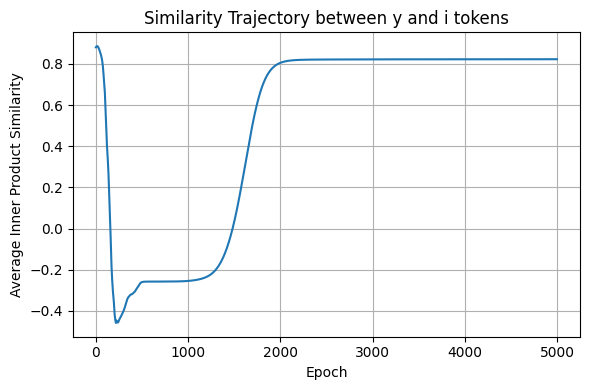

In [161]:
similarity_curves = {}
for contrast_pair in [("ø", "o"), ("ɛ", "ʌ"), ("i", "ɛ"), ("y", "u"), ("u", "o"), ("y", "i")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["testing_activations"], labels_test, label_a=label_a, label_b=label_b, 
                                              calculator=average_cosine_similarity)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:])
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [143]:
similarity_curves.keys()

dict_keys([('ø', 'o'), ('ɛ', 'ʌ'), ('i', 'ɛ'), ('y', 'u'), ('u', 'o'), ('y', 'i')])

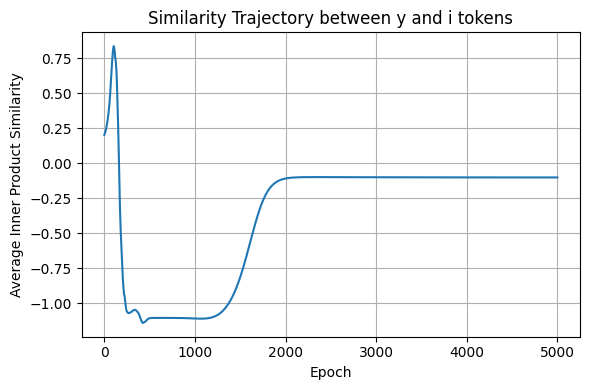

In [162]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[('y', 'i')] - similarity_curves[('i', 'ɛ')])[:])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

In [145]:
# set parameters
num_samples = sum(sizes_train)
epochs = 5000
lr = 0.001
reg_param = 0.5
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_971751/1268316.py:23: SyntaxWarning: invalid escape sequence '\g'
  label='Theory ($\gamma = 0$)')
/tmp/ipykernel_971751/1268316.py:26: SyntaxWarning: invalid escape sequence '\g'
  marker='x', label='Actual ($\gamma = 0$)')
/tmp/ipykernel_971751/1268316.py:36: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)


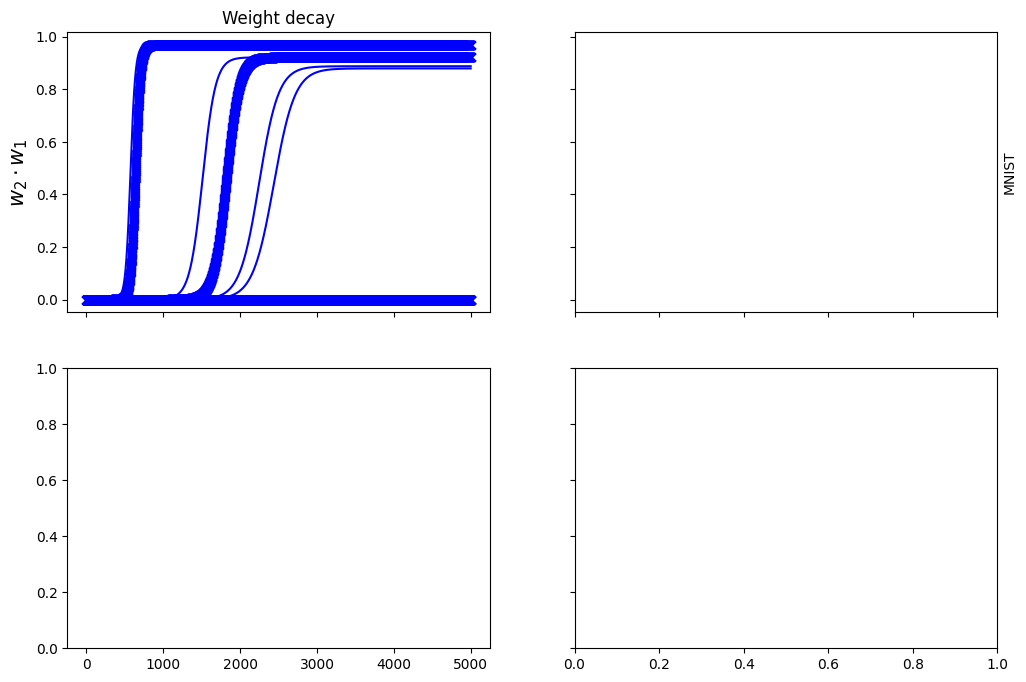

In [163]:
# create dynamics plot
slices = (0, 1, 2, 3)
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(12, 8), sharey='row', sharex='col')
axes = [ax1, ax2]

# get actual dynamics
actual_dynamics_mnist = recorded_models[0].strenghts.cpu().numpy()
# actual_dynamics_reg_mnist = recorded_models[1].strenghts.cpu().numpy()
# actual_dynamics_mnist = recorded_models[0].history['weights']['W1']
# actual_dynamics_reg_mnist = recorded_models[1].history['weights']['W1']
# actual_dynamics_noise_mnist = mnist_models[2].strenghts.cpu().numpy()
w0 = recorded_models[0].init
theoretical_dynamics_reg = theoretical_learning_dynamics(
                                data_train, 
                                data_train, 
                                n_epoch=epochs, lr=lr, var=0, 
                                reg=reg_param, u0 = w0)

# plot simulated dynamics
x_p = np.arange(0, epochs+1, 1)
rangestart = 0
ax1.plot(theoretical_dynamics_reg[:, slices], c='blue', 
         label='Theory ($\gamma = 0$)')
for s in slices:
    ax1.scatter(x_p[rangestart:], actual_dynamics_mnist[rangestart:, s], c='blue', 
                marker='x', label='Actual ($\gamma = 0$)')
    # ax1.scatter(x_p[rangestart:], actual_dynamics_reg_mnist[rangestart:, s], c='orange', 
    #             marker='x', label='Actual ($\gamma = $' + str(reg_param) + ')')
    # ax2.scatter(x_p, actual_dynamics_mnist[:, s], c='blue', 
    #             marker='x', label='Actual ($\sigma^2 = 0$)')
    # ax2.scatter(x_p, actual_dynamics_noise_mnist[:, s], c='darkgreen',
    #             marker='x', label='Actual ($\sigma^2 = $' + str(var_param) + ')')
    
    
# set plot titles and axis labels
ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)
ax1.set_title('Weight decay')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('MNIST')
plt.show()

### Plots for Checking

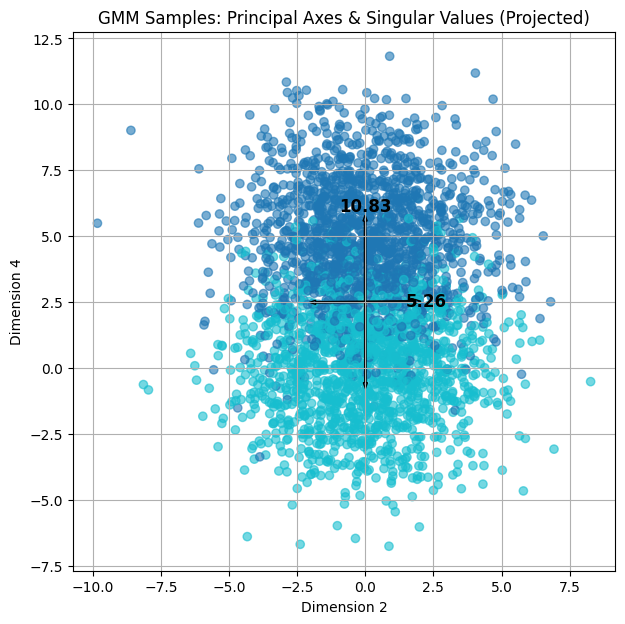

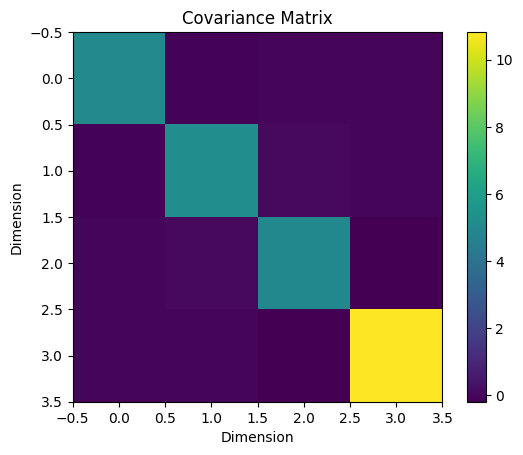

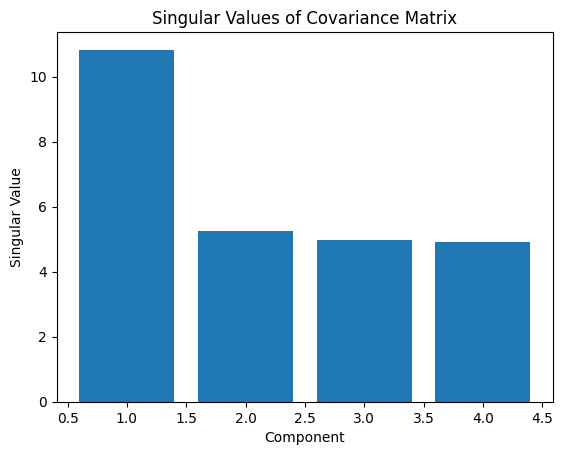

In [113]:
plot_2d_projection_with_principal_axes(data_train, labels_train, dim_x=1, dim_y=3)

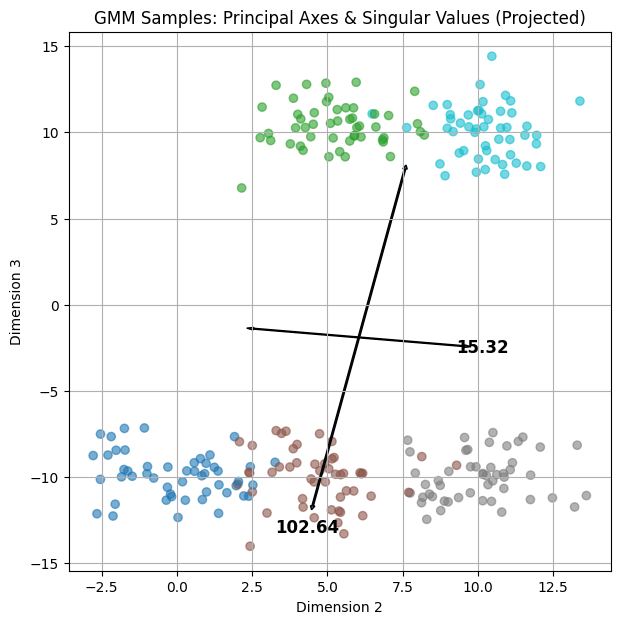

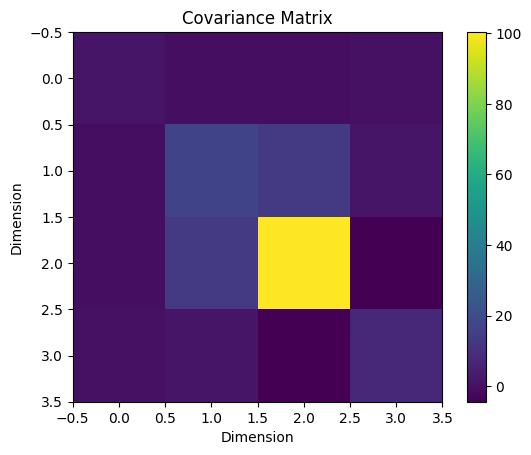

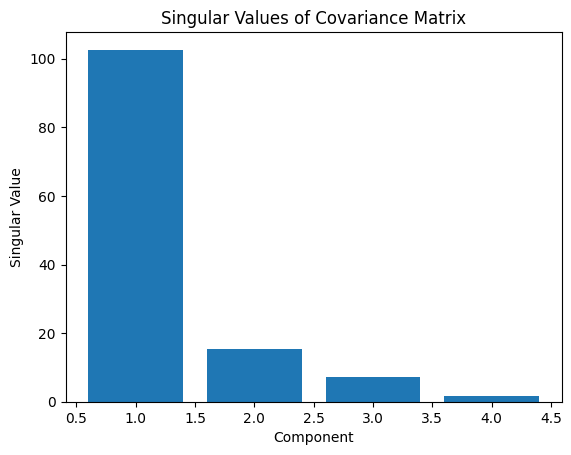

In [21]:
plot_2d_projection_with_principal_axes(data_test, labels_test, dim_x=1, dim_y=2)

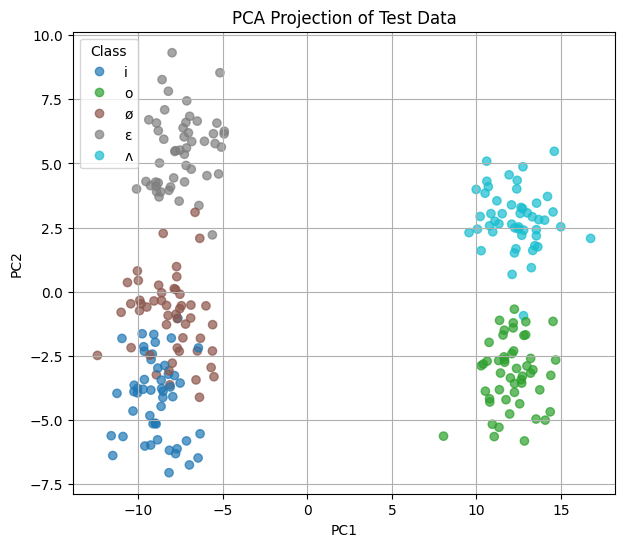

In [28]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_test)
label_names, labels_numeric = np.unique(labels_test, return_inverse=True)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_numeric, cmap='tab10', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of Test Data')
plt.grid(True)

# Matching legend
handles, _ = scatter.legend_elements(prop="colors", alpha=0.7)
plt.legend(handles, label_names, title='Class')
plt.show()